## Applied ML Summative

<mark>**All code and data files needed to reproduce the results in the submission by candidate 1078960 are hosted on this anonymous Github repository: <a></a>. This notebook contains only the code.**</mark>

This notebook is organised as follows:

##### TOC (workflow):
- ##### Stage 1: Data Cleaning
- ##### Stage 2: Data Imputation
- ##### Stage 3: Feature Selection
- ##### Stage 4: Model Building and Training (In-Sample)
- ##### Stage 5: Model Evaluation (Out-of-Sample)
- ##### Stage 6: Interpretability Analysis
- ##### Other Visualisation Code
<!-- - `background_reduced_withMissingCodes.csv`: same as `background_reduced` but with original FFC missing codes preserved
- `bg_reduced_categorical_withMissingCodes.csv`: background file containing only categorical features, with zero-variance and high-missingness variables removed
- `bg_reduced_continuous_withMissingCodes.csv`: background file containing only continuous features, with zero-variance and high-missingness variables removed -->

In [2]:
import os, itertools, pickle
import pandas as pd
import numpy as np
import shap
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt

from sklearn.impute import SimpleImputer, KNNImputer
from sklearn.model_selection import train_test_split

from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.linear_model import Lasso, ElasticNet, LogisticRegression
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn import svm
from xgboost import XGBRegressor, XGBClassifier
from imblearn.over_sampling import SMOTE
from imblearn.combine import SMOTEENN

# Visualisations

data_dir = os.pardir + '/data/'
out_dir = os.pardir + '/output/'

pd.set_option('display.precision', 2) # format displayed to 2 decimal places   
pd.options.display.float_format = '{:.2f}'.format

## Stage 1: Data Cleaning

Input:
- `background.csv`: original file containing 4,242 rows (one per family) and 13,027 columns—background variables asked from birth to age 9
- `FFMetadata_v13_UTF.csv`: latest variable metadata file released by FFC (https://metadata.ffcws.princeton.edu/about)

Output:
- `background_cleaned.csv`: background file with zero-variance and high-missingness variables removed, and one-hot encodings for all categorical variables as well as indicators for missing responses due to "don't know" and "refuse"
- `features.csv`: features metadata file

In [5]:
## Load background data from FFC
bg = pd.read_csv(data_dir+'FFChallenge_v5/background.csv', index_col='challengeID', low_memory=False)
print(f"Background file has initial dimensions: {bg.shape}")
print("")

Background file has initial dimensions: (4242, 13026)


### 1.1 Remove columns with > 80% missing data and columns with zero variance or < 0.05 standard deviation 

In [6]:
## Create copy to preserve Missing Codes
bg_reduced = bg.copy()

## Replace missing codes with NaN
bg_reduced.replace({
    -1: np.NaN, -2: np.NaN, -3: np.NaN,
    -4: np.NaN, -5: np.NaN, -6: np.NaN, 
    -7: np.NaN, -8: np.NaN, -9: np.NaN, 
    np.inf: np.NaN, -np.inf: np.NaN
}, inplace=True)

bg_reduced.replace("Missing", np.NaN, inplace=True)

constant_lst = pd.read_csv(data_dir+'FFChallenge_v5/constantVariables.txt', header=None)
constant_lst.columns = ['constant_var']
bg_reduced.drop(columns = constant_lst['constant_var'], inplace=True)
print(f"Removed {bg.shape[1] - bg_reduced.shape[1]} ({round((bg.shape[1] - bg_reduced.shape[1])/bg.shape[1],2)*100}% of initial number of features) constant variables, leaving {bg_reduced.shape[1]} variables")

variables = bg_reduced.columns

for var in variables:
    if sum(pd.isnull(bg_reduced[var])) > bg_reduced.shape[0] * 0.8:
        bg_reduced.drop(var, axis=1, inplace=True) 

std = bg_reduced.std(axis=0, numeric_only=True)
std = std.where(std < 0.05).isna()
bg_reduced = bg_reduced[std.index[std]]

print(f"Removed {len(variables) - bg_reduced.shape[1]} ({round((len(variables) - bg_reduced.shape[1]) / bg.shape[1], 2)*100} % of initial number of features) variables with > 80% missing data or < 0.05 standard deviation, leaving {bg_reduced.shape[1]} variables")

Removed 2432 (19.0% of initial number of features) constant variables, leaving 10594 variables
Removed 5449 (42.0 % of initial number of features) variables with > 80% missing data or < 0.05 standard deviation, leaving 5145 variables


### 1.2 Identify continuous, categorical and ordinal variables

In [7]:
# Load reduced background and FFC metadata files
bg = bg[bg_reduced.columns]
meta = pd.read_csv(data_dir + 'FFMetadata_v13_UTF.csv', low_memory=False)

meta = meta[['new_name', 'varlab', 'type']]
meta['type'] = meta['type'].apply(lambda x: str(x))
meta = meta[meta.type.isin(['Binary', 'Unordered Categorical', 'Ordered Categorical', 'Continuous'])]
meta.columns = ['variable', 'label', 'type']
meta['type'] = meta['type'].apply(lambda x: 'Unordered Categorical' if x == 'Binary' else x)

features = meta[meta['variable'].isin(bg.columns)].copy()
print(f"Using the latest FFC metadata file (https://metadata.ffcws.princeton.edu/about), \nwe have identified {features.shape[0]} variables: {features[features['type']=='Continuous'].shape[0]} continuous, {features[features['type']=='Unordered Categorical'].shape[0]} categorical, {features[features['type']=='Ordered Categorical'].shape[0]} ordinal, and {len(set(bg.columns) - set(features['variable']))} unknown variables.")

# Some background variables were not documented in metadata file; label the types of these unknown variables based on a few heuristics
unknown_vars =  set(bg.columns) - set(features.variable)
unknown_vars = list(unknown_vars)

pattern = re.compile(r'(how.*?(?:is|many|often|much|long))|rate|frequency|number|#|level|highest|amount|days|total|scale|times', re.IGNORECASE)

for var in unknown_vars:
    ## Heuristic 1: More than 15 Unique Answers -> continuous
    if bg[var].nunique() > 15:
        features.loc[len(features.index)] = [var, np.NaN, 'Continuous']
        
    ## Heuristic 2: Identify ordinal variables using common keywords in ordinal question, similar to Rigobon et al. (2019)        
    elif bool(pattern.search(var)):
        features.loc[len(features.index)] = [var, np.NaN, 'Ordered Categorical']
        
    ## Heuristic 3: Other unknowns are assumed to be categorical
    else:
        features.loc[len(features.index)] = [var, np.NaN, 'Unordered Categorical']
    
print(f"\nAfter identifying the unknown variables based on heuristics, \nwe have {features.shape[0]} variables: {features[features['type']=='Continuous'].shape[0]} continuous, {features[features['type']=='Unordered Categorical'].shape[0]} categorical, {features[features['type']=='Ordered Categorical'].shape[0]} ordinal, and {features[features['type']=='unknown'].shape[0]} unknown variables.")

Using the latest FFC metadata file (https://metadata.ffcws.princeton.edu/about), 
we have identified 5088 variables: 646 continuous, 2584 categorical, 1858 ordinal, and 57 unknown variables.

After identifying the unknown variables based on heuristics, 
we have 5145 variables: 681 continuous, 2606 categorical, 1858 ordinal, and 0 unknown variables.


In [8]:
# Add indicator variables for "Refuse to Answer" or "Don't Know" missing responses for ordinal and continuous variables
df_refuse_dontknow = bg.copy()

df_refuse_dontknow['refuse_check'] = df_refuse_dontknow.where(df_refuse_dontknow == -1, other=0, axis=0).sum(axis=1) 
df_refuse_dontknow['refuse'] = df_refuse_dontknow['refuse_check'].apply(lambda x: 1 if x < 0 else 0)

df_refuse_dontknow['dontknow_check'] = df_refuse_dontknow.where(df_refuse_dontknow == -2, other=0, axis=0).sum(axis=1) 
df_refuse_dontknow['dontknow'] = df_refuse_dontknow['dontknow_check'].apply(lambda x: 1 if x < 0 else 0)
df_refuse_dontknow = df_refuse_dontknow[['refuse', 'dontknow']]

bg_encoded = bg.merge(df_refuse_dontknow, left_index=True, right_index=True)

features = pd.concat([features, pd.DataFrame({
            'variable': ['dontknow', 'refuse'],
            'label': ['Dont Know', 'Refuse'],
            'type': ['Unordered Categorical', 'Unordered Categorical']
        })])

print(f"After adding indicator variables for 'refuse' and 'dont know' missing responses, we have a total of {bg_encoded.shape[1]} features.")

bg_encoded.replace({
    -1: np.NaN, -2: np.NaN, -3: np.NaN, 
    -4: np.NaN, -5: np.NaN, -6: np.NaN, 
    -7: np.NaN, -8: np.NaN, -9: np.NaN, 
    np.inf: np.NaN, -np.inf: np.NaN
}, inplace=True)

bg_encoded.to_csv(data_dir + 'background_cleaned.csv')
features.to_csv(data_dir + 'features.csv')

After adding indicator variables for 'refuse' and 'dont know' missing responses, we have a total of 5147 features.


In [ ]:
# Identify categorical features from variable metadata

## Load variable metadata provided by FFC
meta = pd.read_csv(data_dir + 'ffc_variable_types.csv')
bg = pd.read_csv(data_dir + 'background_reduced_withMissingCodes.csv')

np.random.seed(0)
meta['label'] = meta['label'].apply(lambda x: str(x))

## Features after removing based on missing-ness and low variance
features = meta[meta['variable'].isin(bg.columns)].drop(0)

## More than 15 Unique Answers -> continuous
features.loc[(features['unique_values'] > 15), 'variable_type'] = 'continuous'

## Identify ordinal variables using keywords
pattern = re.compile(r'(how.*?(?:is|many|often|much|long))|rate|frequency|number|#|level|highest|amount|days|total|scale|times', re.IGNORECASE)
matches = features['label'].apply(lambda x: bool(pattern.search(x)))
features.loc[(matches) & (features['variable_type'] != 'continuous'), 'variable_type'] = 'Ordered Categorical'

## Other unknowns are assumed to be categorical

features.loc[features['variable_type'] == 'unknown', 'variable_type'] = 'categorical'

print(f"Out of {features.shape[0]} variables, identified {features[features['variable_type']=='continuous'].shape[0]} continuous, {features[features['variable_type']=='categorical'].shape[0]} categorical, {features[features['variable_type']=='ordinal'].shape[0]} ordinal variables, leaving {features[features['variable_type']=='unknown'].shape[0]} unknown variables.")

## Stage 2: Imputation of Missing Values

In [7]:
# Load results from Stage 1 and raw data files
features = pd.read_csv(data_dir+'features.csv')
bg = pd.read_csv(data_dir+'background_cleaned.csv', index_col='challengeID')
train = pd.read_csv(data_dir+'/FFChallenge_v5/train.csv', index_col='challengeID')
y_out_sample = pd.read_csv(data_dir+'/FFChallenge_v5/test.csv', index_col='challengeID')
x_out_sample = bg.loc[y_out_sample.index.values]
print(f'in-sample number of observations: {train.shape[0]} \nout-of-sample number of observations: {x_out_sample.shape[0]}')

in-sample number of observations: 2121 
out-of-sample number of observations: 1591


### 2.1 Split data set into train, validation and test sets

In [ ]:
cat_vars = features[(features['type'] == 'Unordered Categorical') | (features['type'] == 'Ordered Categorical')].variable
cont_vars = features[(features['type'] == 'Continuous')].variable
bg_train = bg.loc[train.index]

# x_train, x_test, y_train, y_test = train_test_split(bg_train, train, test_size=0.33, random_state=7)
# print(f"x_train shape: {x_train.shape} \ny_train shape: {x_test.shape}")

### 2.2 Perform simple imputation - mean for continuous and mode for categorical variables 
(also impute out-sample X based on in-sample X_train for out-sample prediction later)

In [ ]:
x_train_cat = x_train[cat_vars].copy()
x_test_cat = x_test[cat_vars].copy()
x_out_sample_cat = x_out_sample[cat_vars].copy()
x_train_cont = x_train[cont_vars].copy()
x_test_cont = x_test[cont_vars].copy()
x_out_sample_cont = x_out_sample[cont_vars].copy()

# Perform simple mode imputation on categorical variables
imp_mode = SimpleImputer(strategy='most_frequent')
imp_mode.fit(x_train_cat)
x_train_cat_imputed = imp_mode.transform(x_train_cat)
x_train_cat_imputed = pd.DataFrame(x_train_cat_imputed, index=x_train_cat.index, columns=x_train_cat.columns)
x_test_cat_imputed = imp_mode.transform(x_test_cat)
x_test_cat_imputed = pd.DataFrame(x_test_cat_imputed, index=x_test_cat.index, columns=x_test_cat.columns)
x_out_sample_cat_imputed = imp_mode.transform(x_out_sample_cat)
x_out_sample_cat_imputed = pd.DataFrame(x_out_sample_cat_imputed, index=x_out_sample_cat.index, columns=x_out_sample_cat.columns)

# Perform simple mean imputation on continuous variables
imp_mean = SimpleImputer(strategy='mean')
imp_mean.fit(x_train_cont)
x_train_cont_imputed = imp_mean.transform(x_train_cont)
x_train_cont_imputed = pd.DataFrame(x_train_cont_imputed, index=x_train_cont.index, columns=x_train_cont.columns)
x_test_cont_imputed = imp_mean.transform(x_test_cont)
x_test_cont_imputed = pd.DataFrame(x_test_cont_imputed, index=x_test_cont.index, columns=x_test_cont.columns)
x_out_sample_cont_imputed = imp_mean.transform(x_out_sample_cont)
x_out_sample_cont_imputed = pd.DataFrame(x_out_sample_cont_imputed, index=x_out_sample_cont.index, columns=x_out_sample_cont.columns)

x_train_simple = x_train_cat_imputed.merge(x_train_cont_imputed, left_index=True, right_index=True)
x_test_simple = x_test_cat_imputed.merge(x_test_cont_imputed, left_index=True, right_index=True)
x_out_sample_simple = x_out_sample_cat_imputed.merge(x_out_sample_cont_imputed, left_index=True, right_index=True)
X_all_simple = pd.concat([x_train_simple, x_test_simple, x_out_sample_simple])

# print(x_train_simple.isna().sum(axis=1).max())
# print(x_test_simple.isna().sum(axis=1).max())
# print(x_out_sample_simple.isna().sum(axis=1).max())

### 2.3 Perform k-Nearest Neighbor Imputation (mean)

In [25]:
# Create x_train, x_test for kNN imputation in R notebook
x_train_knn = x_train.copy()
x_test_knn = x_test.copy()
x_out_sample_knn = x_out_sample.copy()

imp_knn = KNNImputer(n_neighbors=5)
imp_knn.fit(x_train_knn)
x_train_knn_imputed = imp_knn.transform(x_train_knn)
x_train_knn_imputed = pd.DataFrame(x_train_knn_imputed, index=x_train_knn.index, columns=x_train_knn.columns)
x_test_knn_imputed =  imp_knn.transform(x_test_knn)
x_test_knn_imputed = pd.DataFrame(x_test_knn_imputed, index=x_test_knn.index, columns=x_test_knn.columns)
x_out_sample_knn_imputed =  imp_knn.transform(x_out_sample_knn)
x_out_sample_knn_imputed = pd.DataFrame(x_out_sample_knn_imputed, index=x_out_sample_knn.index, columns=x_out_sample_knn.columns)

# Define helper function to clean up categorical variable imputation
def clean_imputed_categorical(categories, original_col, imputed_col): 
    new_col = list(original_col)
    for i, j in enumerate(original_col):
        # If value is missing, then get its imputed value 
        if j != j: 
            predicted = list(imputed_col)[i]
            # Distance of pred from all categories
            diffs = []
            for c in categories: 
                diffs.append(abs(predicted - c))
                #Get index for minimum value
                min_idx = diffs.index(min(diffs)) 
                closest_cat = categories[min_idx] 
                new_col[i] = closest_cat
    return new_col

unique_cat_values_dict = {}

for var in cat_vars:
    col = bg_train[var].dropna()
    unique_cat_values_dict[var] = col.unique()
    
for var in cat_vars:
    categories = list(unique_cat_values_dict[var])
    
    original_col = x_train_knn_imputed[var]
    imputed_col = x_train_knn_imputed[var]
    new_col = clean_imputed_categorical(categories, original_col, imputed_col)
    x_train_knn_imputed[var] = new_col

    original_col = x_test_knn_imputed[var]
    imputed_col = x_test_knn_imputed[var]
    new_col = clean_imputed_categorical(categories, original_col, imputed_col)
    x_test_knn_imputed[var] = new_col

    original_col = x_out_sample_knn_imputed[var]
    imputed_col = x_out_sample_knn_imputed[var]
    new_col = clean_imputed_categorical(categories, original_col, imputed_col)
    x_out_sample_knn_imputed[var] = new_col

# Save output
# x_train_knn_imputed.to_csv(data_dir+'x_train_knnImputed.csv') 
# x_test_knn_imputed.to_csv(data_dir+'x_test_knnImputed.csv') 
# x_out_sample_knn_imputed.to_csv(data_dir+'x_out_sample_knnImputed.csv')

### 2.3 One-Hot Encode Categorical Variables

In [11]:
train_simple = x_train_simple.copy()
test_simple = x_test_simple.copy()
out_sample_simple = x_out_sample_simple.copy()

train_idx = train_simple.index
test_idx = test_simple.index
out_sample_idx = out_sample_simple.index

data_simple = pd.get_dummies(pd.concat([train_simple, test_simple, out_sample_simple]), columns=cat_vars, dtype='int')

x_train_simple_imputed = data_simple.loc[train_idx]
x_test_simple_imputed = data_simple.loc[test_idx]
x_out_sample_simple_imputed = data_simple.loc[out_sample_idx]

# Save output
# x_train_simple_imputed.to_csv(data_dir+'x_train_simpleImputed.csv')
# x_test_simple_imputed.to_csv(data_dir+'x_test_simpleImputed.csv')
# x_out_sample_simple_imputed.to_csv(data_dir+'x_out_sample_simpleImputed.csv')
print(f"After one-hot encoding categorical variables, \nx_train dimension: {x_train_simple_imputed.shape} \nx_test dimension {x_test_simple_imputed.shape}.")

After one-hot encoding categorical variables, 
x_train dimension: (1421, 19376) 
x_test dimension (700, 19376).


## Stage 4: Model Building and Training

In [3]:
# Load simple-imputed data
x_train_simple = pd.read_csv(data_dir+'x_train_simpleImputed.csv', index_col='challengeID')
x_test_simple = pd.read_csv(data_dir+'x_test_simpleImputed.csv', index_col='challengeID')

# Load knn-imputed data
x_train_knn = pd.read_csv(data_dir+'x_train_knnImputed_noEncoding.csv', index_col='challengeID')
x_test_knn = pd.read_csv(data_dir+'x_test_knnImputed_noEncoding.csv', index_col='challengeID')

# Load outcomes data
train = pd.read_csv(data_dir+'FFChallenge_v5/train.csv', index_col='challengeID') 
# Load features metadata
features = pd.read_csv(data_dir+'features.csv')

# Load mutual information selected features file
with open(data_dir+'outcome_best_k.pkl', 'rb') as f:
    mi_best_k_dict_source = pickle.load(f)
with open(data_dir+'outcome_best_k_knn.pkl', 'rb') as f:
    mi_best_k_dict_knn_source = pickle.load(f)

# Load LASSO selected features file
with open(data_dir+'lasso_outcome_alpha_feature_dict.pkl', 'rb') as f:
    lasso_features_dict_source = pickle.load(f)
with open(data_dir+'lasso_outcome_alpha_feature_knn_dict.pkl', 'rb') as f:
    lasso_features_dict_knn_source = pickle.load(f)

# Reformat selected features dictionary for ease-of-use in model training functions
k_range = list(mi_best_k_dict_knn_source['eviction'].keys()) # using one outcome 'eviction' to get all k's since the k range is the same across all outcomes
outcomes = list(mi_best_k_dict_knn_source.keys())

mi_best_k_dict_simple = {}
mi_best_k_dict_knn = {}

for k in k_range:
    mi_best_k_dict_simple[k] = {}
    mi_best_k_dict_knn[k] = {}

    for outcome in outcomes:
        mi_best_k_dict_simple[k][outcome] = mi_best_k_dict_source[outcome][k]
        mi_best_k_dict_knn[k][outcome] = mi_best_k_dict_knn_source[outcome][k]

lasso_features_dict_simple = {}
lasso_features_dict_knn = {}

for outcome in outcomes:
    lasso_features_dict_simple[outcome] = lasso_features_dict_source[outcome]['features']
    lasso_features_dict_knn[outcome] = lasso_features_dict_knn_source[outcome]['features']

### 4.1 Define model-building workflow, wrapper functions and candidate models

To build a pipeline for training and evaluating all models with all possible configurations for each FFC outcome, I consider all possible combinations of these 4 "metaparameters":
- Missing Data Imputation Method: Simple imputation (mean for continuous, mode otherwise) vs. Multiple imputation (kNN)
- Feature Selection Method: LASSO vs. Mutual Information vs. None (all variables)
- Resampling: Upsample, Downsample or None
- Standardisation of continuous: with vs. without
  
I separate the model development stage into two workflows on which my code architecture is based:
1. Optimise at the hyperparameter-level: Given a set of metaparameters, train, tune and select the best model for each outcome (`trainModels` function)
2. Optimise at the metaparameter-level: Given the best model based on every possible set of metaparameters, select the best meta-parameter along with the corresponding tuned model (`trainModelsMeta` function)

Outcome variable: `global_best_dict` dictionary of all model evaluation results for each outcome (see schema below)

In [3]:
# Empty variables to document schema for two model training results dictionaries
outcome_global_best_dict_schema = {
          'best_mse' : 'lowest in-sample test MSE achieved',
          'best_r2' : 'corresponding in-sample test R2',
          'best_r2_holdout': 'corresponding in-sample holdout R2 (Salganik et al., 2020)',
          'best_metaparams': 'corresponding set of the metaparameters',
          'best_model_res_dict': 'dictionary of the best results for each model under best metaparameters'
}

model_res_dict_schema = {
    'model type idx': {
        'model': 'sklearn tuned GridSearchCV or RandomizedSearchCV object corresponding to the best model',
        'test_mse': 'test mse achieved by the model given a set of metaparameter (see meta_param_res_dict)',
        'best_r2' : 'corresponding in-sample test R2',
        'best_r2_holdout': 'corresponding in-sample holdout R2 (Salganik et al., 2020)',
    }
}

In [4]:
def r2_holdout_score(y_holdout, y_pred, y_train):
    '''
    Helper function to compute R2-holdout
    '''
    y_train_bar = np.sum(y_train) / len(y_train)
    ss_res = np.sum((y_holdout - y_pred)**2)
    ss_tot = np.sum((y_holdout - y_train_bar)**2)
    r2_holdout = 1 -  (ss_res / ss_tot) 
    
    return r2_holdout

def trainModels(x_train: pd.DataFrame, y_train: pd.DataFrame, x_test: pd.DataFrame, y_test: pd.DataFrame, 
                model_pipelines: list, model_hyperparams: list):
    '''
    Given an outcome, a list of candidate model pipelines and their corresponding hyperparameters, train and evaluate 
    each candidate model with hyperparameter tuning. Returns a dictionary of model results and the key (index) for the best model.
    ''' 
    # Dictionary to keep track of eval results for each model
    model_res_dict = {}
    best_test_mse = 1
    
    for idx, pipeline in enumerate(model_pipelines):
        model_res_dict[idx] = {}
            
        search_strategy = model_hyperparams[idx][-1]

        if search_strategy == 'random_search':
            model = RandomizedSearchCV(estimator=pipeline, param_distributions=model_hyperparams[idx][:-1], 
                       scoring='neg_mean_squared_error', cv=5, n_jobs=-1)
        else:
            model = GridSearchCV(estimator=pipeline, param_grid=model_hyperparams[idx][:-1],
                       scoring='neg_mean_squared_error', cv=5, n_jobs=-1)
                       
        #print(f"Fitting model...")
        model.fit(x_train, y_train)
        y_pred = model.predict(x_test)

        # Save results
        model_res_dict[idx]['model'] = model
        model_res_dict[idx]['test_mse'] = mean_squared_error(y_test, y_pred)
        model_res_dict[idx]['r2'] = r2_score(y_test, y_pred)
        model_res_dict[idx]['r2_holdout'] = r2_holdout_score(y_test, y_pred, y_train)
        model_res_dict[idx]['train_mse'] = (model.best_score_ * -1)
        
        if model_res_dict[idx]['test_mse'] < best_test_mse:
            best_test_mse = model_res_dict[idx]['test_mse']
            best_model_idx = idx
        
    return model_res_dict, best_model_idx

def trainModelsMeta(outcome, meta_param_lst, pipelines: list, hyperparams: list, imputation_method_dict: dict, features: pd.DataFrame):
    '''
    Given outcome, metaparameters list, candidate model pipeliens and hyperparameters alongside other reference feature dictionaries,
    returns two dictionaries: one containing the best model results and corresponding best metaparameters for each outcome, and
    the other containing the best model results given each metaparameter for each outcome.
    '''
    meta_param_res_dict = {}
    outcome_global_best_dict = {}
    errors = []

    for meta_param_idx, meta_param in enumerate(meta_param_lst):
        print(f'Training on metaparams #{meta_param_idx + 1} of {len(meta_param_lst)}')

        # try:
        meta_param_res_dict[meta_param_idx] = {}
        meta_param = dict(meta_param)
        
        if outcome not in outcome_global_best_dict:
            outcome_global_best_dict = {}
            outcome_global_best_dict['best_mse'] = 1

        imp_method = meta_param['imputation_method']
        x_train, x_test, y_all  = imputation_method_dict[imp_method]['data']
        y_train = y_all.loc[x_train.index.values]
        y_test = y_all.loc[x_test.index.values]
        y_train = y_train[outcome].dropna()
        y_test = y_test[outcome].dropna()
        x_train = x_train.loc[y_train.index.values]
        x_test = x_test.loc[y_test.index.values]
        
        # Select features for each outcome based on imputation and feature selection methods
        features_selected_ref = meta_param['features_selected']

        if features_selected_ref == 'all':
            features_selected = list(imputation_method_dict[imp_method]['features_selected_dict'][features_selected_ref])
        else:
            features_selected = list(imputation_method_dict[imp_method]['features_selected_dict'][features_selected_ref][outcome])

        x_train = x_train[features_selected]
        x_test = x_test[features_selected]
        
        # Resample
        if 'resampling' in meta_param:
            if meta_param['resampling'] == 'upsample':
                smote = SMOTE(random_state=7)
                x_train, y_train = smote.fit_resample(x_train, y_train) 
            elif meta_param['resampling'] == "downsample":
                smote_enn = SMOTEENN(random_state=7)
                x_train, y_train = smote_enn.fit_resample(x_train, y_train) 
        
        # Standardise features
        if meta_param['standardize']:
            normalizer = StandardScaler()
            cont_vars =  [ var for var in features[features['type'] == 'Continuous'].variable if var in x_train.columns ]
            
            for var in cont_vars:
                normalizer.fit(x_train[var].values.reshape(-1,1))
                x_train[var] = normalizer.transform(x_train[var].values.reshape(-1,1))
                x_test[var] = normalizer.transform(x_test[var].values.reshape(-1,1)) 

        # Find the best model given the metaparameters
        model_res_dict, best_model_idx = trainModels(x_train, y_train, x_test, y_test, pipelines, hyperparams)
        meta_param_res_dict[meta_param_idx]['model_res_dict'] = model_res_dict
        meta_param_res_dict[meta_param_idx]['best_model_idx'] = best_model_idx
        
        if model_res_dict[best_model_idx]['test_mse'] < outcome_global_best_dict['best_mse']:
            outcome_global_best_dict['best_mse'] = model_res_dict[best_model_idx]['test_mse']
            outcome_global_best_dict['best_r2'] = model_res_dict[best_model_idx]['r2']
            outcome_global_best_dict['best_r2_holdout'] = model_res_dict[best_model_idx]['r2_holdout']
            outcome_global_best_dict['best_metaparams'] = meta_param
            outcome_global_best_dict['best_metaparams_idx'] = meta_param_idx
            outcome_global_best_dict['best_model_idx'] = model_res_dict[best_model_idx]
            outcome_global_best_dict['best_model_res_dict'] = model_res_dict
        # except Exception as e:
        #     print('error')
        #     errors.append((outcome, meta_param_idx, e))

    return outcome_global_best_dict, meta_param_res_dict, errors

In [5]:
# Build candidate model pipelines and range of hyperparameters to consider
pipe_lasso_reg = Pipeline([('clf', Lasso(random_state=7))])
pipe_lasso_clf = Pipeline(steps=[('clf', LogisticRegression(solver='saga'))]) 
hyper_lasso_reg    = [{'clf__alpha': np.linspace(0.0, 2.0, num=100)}, 'random_search']
hyper_lasso_clf    = [{'clf__C': [1,2,5], 'clf__penalty': ['l1']}, 'random_search']


pipe_elastic_reg   = Pipeline([('clf', ElasticNet(random_state=7))])
pipe_elastic_clf   = Pipeline([('clf', LogisticRegression(solver='saga'))])
hyper_elastic_reg  = [{'clf__alpha': np.linspace(0.5, 1.0, num=100), 'clf__l1_ratio': np.linspace(0.0, 1.0, num=100)}, 'random_search']
hyper_elastic_clf = [{'clf__penalty': ['elasticnet'], 'clf__C': [1,2,5], 'clf__l1_ratio': np.linspace(0.0, 1.0, num=100)}, 
                     'random_search']

pipe_svm_clf   = Pipeline([('clf', svm.SVC(random_state=7))])
pipe_svm_reg   = Pipeline([('clf', svm.SVR())])
hyper_svm    = [{'clf__kernel': ['rbf'], 'clf__C': [2,5]}, 'grid_search']

pipe_rf_clf  = Pipeline([('clf', RandomForestClassifier(random_state=7))])
pipe_rf_reg  = Pipeline([('clf', RandomForestRegressor(random_state=7))])
hyper_rf     = [{'clf__n_estimators': [50, 500], 'clf__max_features': [100, 150], 'clf__max_depth': [2,3,5], 
                 'clf__min_samples_split': [2,5,10], 'clf__min_samples_leaf': [2,5,10]}, 'grid_search']
pipe_xgb_clf     = Pipeline([('clf', XGBClassifier())])
pipe_xgb_reg     = Pipeline([('clf', XGBRegressor())])
hyper_xgb    = [{'clf__n_estimators': [100, 1000], 'clf__learning_rate': [0.01, 0.05, 0.1], 'clf__min_child_weight': [1, 5, 10], 
                  'clf__max_depth': [2,5], 'clf__colsample_bytree': [0.4, 0.6, 0.8]}, 'grid_search']

pipelines_reg = [ pipe_lasso_reg, pipe_elastic_reg, pipe_svm_reg, pipe_rf_reg, pipe_xgb_reg ]
pipelines_clf  = [ pipe_lasso_clf, pipe_elastic_clf, pipe_svm_clf, pipe_rf_clf, pipe_xgb_clf ]
hyperparams_reg = [ hyper_lasso_reg, hyper_elastic_reg, hyper_svm, hyper_rf, hyper_xgb]
hyperparams_clf = [ hyper_lasso_clf, hyper_elastic_clf, hyper_svm, hyper_rf, hyper_xgb]

# Define metaparameters
meta_params_label = ['imputation_method', 'features_selected', 'resampling', 'scaling' ] 

# Train without all features
features_selected = [('features_selected', 'lasso'), ('features_selected', 'mi_best_50'),
                     ('features_selected', 'mi_best_100'), ('features_selected', 'mi_best_250'), ('features_selected', 'mi_best_500'), 
                     ('features_selected', 'mi_best_1000'), ('features_selected', 'mi_best_2000') ]
features_selected_temp = [('features_selected', 'lasso'), 
                     ('features_selected', 'mi_best_100'), ('features_selected', 'mi_best_500'), 
                     ('features_selected', 'mi_best_1000') ]
imputation_method = [ ('imputation_method','simple'), ('imputation_method', 'knn')]
resampling = [ ('resampling', 'upsample'), ('resampling', 'downsample'), ('resampling', None) ]
scaling = [ ('standardize', True), ('standardize', False) ]

# Define helper dictionaries for features and imputed dataframes

features_selected_dict_simple = {
    'all': list(x_train_simple.columns),
    'lasso': lasso_features_dict_simple,
    'mi_best_50': mi_best_k_dict_simple[50],
    'mi_best_100': mi_best_k_dict_simple[100],
    'mi_best_250': mi_best_k_dict_simple[250],
    'mi_best_500': mi_best_k_dict_simple[500],
    'mi_best_1000': mi_best_k_dict_simple[1000],
    'mi_best_2000': mi_best_k_dict_simple[2000],
}

features_selected_dict_knn = {
    'all': list(x_train_knn.columns),
    'lasso': lasso_features_dict_knn,
    'mi_best_50': mi_best_k_dict_knn[50],
    'mi_best_100': mi_best_k_dict_knn[100],
    'mi_best_250': mi_best_k_dict_knn[250],
    'mi_best_500': mi_best_k_dict_knn[500],
    'mi_best_1000': mi_best_k_dict_knn[1000],
    'mi_best_2000': mi_best_k_dict_knn[2000],
}

imputation_method_dict = {
    'simple': { 
        'data': (x_train_simple.copy(), x_test_simple.copy(), train.copy()),
        'features_selected_dict': features_selected_dict_simple
    },
    'knn': { 
        'data': (x_train_knn.copy(), x_test_knn.copy(), train.copy()),
        'features_selected_dict': features_selected_dict_knn
    }
}

model_label_dict = {
    0: 'Lasso',
    1: 'Elastic Net',
    2: 'Support Vector Machine',
    3: 'Random Forest',
    4: 'Gradient-Boosted Tree'
}

# Get all possible combinations of metaparameters for predicting continuous and binary outcomes
meta_params_reg = list(itertools.product(imputation_method, features_selected, scaling)) 
meta_params_clf = list(itertools.product(imputation_method, features_selected_temp, scaling, resampling)) 

### 4.2 Train Models for All FFC Outcomes

In [ ]:
outcomes = ['gpa', 'grit', 'materialHardship', 'eviction', 'layoff', 'jobTraining']
outcome_model = ['reg', 'reg', 'reg', 'clf', 'clf', 'clf']
errors = {}

# Total runtime: ~ 6h40m (64-Core CPU, NVIDIA A100 GPU, 256GB RAM)
for i, outcome in enumerate(outcomes):
    print(f'\nTraining for {outcome}...')
    meta_params_lst = meta_params_reg if outcome_model[i] == 'reg' else meta_params_clf
    model_pipelines = pipelines_reg if outcome_model[i] == 'reg' else pipelines_clf
    hyperparams = hyperparams_reg if outcome_model[i] == 'reg' else hyperparams_clf
    global_best_dict, meta_params_res_dict, errors_log = trainModelsMeta(outcome, meta_params_reg, model_pipelines, hyperparams, imputation_method_dict, features)
    errors[outcome] = errors_log
    
    # Save results
    # with open(data_dir+f'global_best_dict_{outcome}.pkl', 'wb') as f:
    #     pickle.dump(global_best_dict, f)
    # with open(data_dir+f'meta_param_res_dict_{outcome}.pkl', 'wb') as f:
    #     pickle.dump(meta_param_res_dict, f)

## Stage 5: Model Evaluation (Out-of-Sample)

In [6]:
# Load previously imputed out-of-sample background data (X) using imputation fitted on x_train sample (but not in-sample x_test)
x_out_sample_simple = pd.read_csv(data_dir+'x_out_sample_simpleImputed.csv', index_col='challengeID')
x_out_sample_knn = pd.read_csv(data_dir+'x_out_sample_knnImputed.csv', index_col='challengeID')
out_sample = pd.read_csv(data_dir+'/FFChallenge_v5/test.csv', index_col='challengeID')

In [7]:
# Define helper and wrapper functions for model evaluation
def evaluateModels(outcomes, out_sample, x_out_sample_simple, x_out_sample_knn, imputation_method_dict, model_label_dict):
    ''' 
    Given the out-of-sample prediction dataset, compute out-of-sample MSE and R2_holdout for 
    each of the best-tuned models. Returns  a dataframe of all in-sample and out-of-sample MSEs 
    and R2_holdouts for each outcome.  
    '''
    df_ret = {}

    for outcome in outcomes:
        with open(data_dir+f'global_best_dict_{outcome}.pkl', 'rb') as f:
            global_best_dict = pickle.load(f)
        
        estimator_lasso = global_best_dict['best_model_res_dict'][0]['model'].best_estimator_
        estimator_elastic = global_best_dict['best_model_res_dict'][1]['model'].best_estimator_
        estimator_svm = global_best_dict['best_model_res_dict'][2]['model'].best_estimator_
        estimator_rf = global_best_dict['best_model_res_dict'][3]['model'].best_estimator_
        estimator_xgb = global_best_dict['best_model_res_dict'][4]['model'].best_estimator_
        estimator_lst = [ estimator_lasso, estimator_elastic, estimator_svm, estimator_rf, estimator_xgb ]

        meta_params = global_best_dict['best_metaparams']
        x_out_sample, y_out_sample, y_train = feature_transform_metaparams(outcome, meta_params, out_sample, x_out_sample_simple, x_out_sample_knn, 
                                                                            imputation_method_dict, return_y_train=True)
        
        model_name  = []
        mse_in_sample = []
        r2_in_sample = [] 
        mse_out_sample = []
        r2_out_sample = []

        for idx, model in enumerate(estimator_lst):    
            y_pred = model.predict(x_out_sample)
            model_name.append(model_label_dict[idx])
            mse_out_sample.append(mean_squared_error(y_out_sample, y_pred))
            r2_out_sample.append(r2_holdout_score(y_out_sample, y_pred, y_train))
            mse_in_sample.append(global_best_dict['best_model_res_dict'][idx]['test_mse'])
            r2_in_sample.append(global_best_dict['best_model_res_dict'][idx]['r2_holdout'])
            
        df_ret[outcome] = pd.DataFrame.from_dict({
            'Model': model_name, 
            'In-Sample Test MSE': mse_in_sample,
            'In-Sample Test R2': r2_in_sample,
            'Out-of-Sample MSE': mse_out_sample,
            'Out-of-Sample R2': r2_out_sample,
        })     
    
    return df_ret

def feature_transform_metaparams(outcome: str, meta_params: dict, out_sample: pd.DataFrame, x_out_sample_simple: pd.DataFrame, 
                                 x_out_sample_knn: pd.DataFrame, imputation_method_dict: dict, return_y_train: bool=False, return_train_average: bool=False):
    '''
    Given an outcome and metaparameters, transform x test based on optimized metaparameters for prediction task 
    '''
    imp_method = meta_params['imputation_method']
    data = imputation_method_dict[imp_method]['data']
    x_train, x_test, train = data
    y_train = train.loc[x_train.index.values][outcome].dropna()
    y_train2 = train.loc[x_test.index.values][outcome].dropna()
    x_train = x_train.loc[y_train.index.values]
    x_out_sample = x_out_sample_simple if imp_method == 'simple' else x_out_sample_knn
    y_out_sample = out_sample.loc[x_out_sample.index.values]
    y_out_sample = y_out_sample[outcome].dropna()
    x_mask = y_out_sample.index.values
    x_out_sample = x_out_sample.loc[x_mask]
    y_train = pd.concat([y_train, y_train2])

    features_selected_ref = meta_params['features_selected']
    features_selected = list(imputation_method_dict[imp_method]['features_selected_dict'][features_selected_ref][outcome])
    x_out_sample = x_out_sample[features_selected]

    # Standardise features
    if meta_params['standardize']:
        normalizer = StandardScaler()
        cont_vars =  [ var for var in features[features['type'] == 'Continuous'].variable if var in x_out_sample.columns ]
        
        for var in cont_vars:
            normalizer.fit(x_train[var].values.reshape(-1,1))
            x_out_sample[var] = normalizer.transform(x_out_sample[var].values.reshape(-1,1))
    
    # Compute in-sample outcome average for baseline calculations
    if return_y_train:
        return x_out_sample, y_out_sample, y_train
    else:
        return x_out_sample, y_out_sample

### Stage 5.1: Out-of-Sample Prediction

In [6]:
#outcomes = ['gpa', 'grit', 'materialHardship', 'eviction', 'layoff', 'jobTraining']
#model_eval_results = evaluateModels(outcomes, out_sample, x_out_sample_simple, x_out_sample_knn, imputation_method_dict, model_label_dict)
with open(data_dir+'model_eval_results_final.pkl', 'rb') as f:
    model_eval_results = pickle.load(f)

In [19]:
print('GPA results:')
res_gpa = model_eval_results['gpa'].sort_values(by='Out-of-Sample R2', ascending=False)
display(res_gpa)

print('Grit results:')
res_grit = model_eval_results['grit'].sort_values(by='Out-of-Sample R2', ascending=False)
display(res_grit)

print('Material Hardship results:')
res_material = model_eval_results['materialHardship'].sort_values(by='Out-of-Sample R2', ascending=False)
display(res_material)

GPA results:


,Model,In-Sample Test MSE,In-Sample Test R2,Out-of-Sample MSE,Out-of-Sample R2
4,Gradient-Boosted Tree,0.40,0.16,0.35,0.17
3,Random Forest,0.40,0.17,0.36,0.16
1,Elastic Net,0.44,0.08,0.40,0.06
0,Lasso,0.44,0.08,0.40,0.06
2,Support Vector Machine,0.47,0.02,0.42,0.01


Grit results:


,Model,In-Sample Test MSE,In-Sample Test R2,Out-of-Sample MSE,Out-of-Sample R2
3,Random Forest,0.22,0.03,0.25,0.03
4,Gradient-Boosted Tree,0.23,0.02,0.25,0.02
0,Lasso,0.25,-0.06,0.26,-0.04
1,Elastic Net,0.25,-0.06,0.27,-0.05
2,Support Vector Machine,0.26,-0.10,0.28,-0.11


Material Hardship results:


,Model,In-Sample Test MSE,In-Sample Test R2,Out-of-Sample MSE,Out-of-Sample R2
4,Gradient-Boosted Tree,0.02,0.15,0.02,0.19
3,Random Forest,0.02,0.16,0.02,0.18
0,Lasso,0.02,0.03,0.02,0.01
1,Elastic Net,0.02,0.02,0.02,0.01
2,Support Vector Machine,0.02,-0.00,0.03,-0.03


In [20]:
print('Eviction results:')
res_evict = model_eval_results['eviction'].sort_values(by='Out-of-Sample R2', ascending=False)
display(res_evict)

print('Layoff results:')
res_layoff = model_eval_results['layoff'].sort_values(by='Out-of-Sample R2', ascending=False)
display(res_layoff)

print('jobTraining results:')
res_job = model_eval_results['jobTraining'].sort_values(by='Out-of-Sample R2', ascending=False)
display(res_job)

Eviction results:


,Model,In-Sample Test MSE,In-Sample Test R2,Out-of-Sample MSE,Out-of-Sample R2
1,Elastic Net,0.06,-0.06,0.06,-0.06
3,Random Forest,0.06,-0.06,0.06,-0.06
2,Support Vector Machine,0.06,-0.06,0.06,-0.06
4,Gradient-Boosted Tree,0.06,-0.14,0.06,-0.11
0,Lasso,0.11,-0.91,0.10,-0.81


Layoff results:


,Model,In-Sample Test MSE,In-Sample Test R2,Out-of-Sample MSE,Out-of-Sample R2
3,Random Forest,0.16,0.00,0.17,0.01
0,Lasso,0.16,-0.01,0.17,-0.02
4,Gradient-Boosted Tree,0.16,-0.03,0.17,-0.04
1,Elastic Net,0.17,-0.05,0.18,-0.06
2,Support Vector Machine,0.17,-0.07,0.18,-0.08


jobTraining results:


,Model,In-Sample Test MSE,In-Sample Test R2,Out-of-Sample MSE,Out-of-Sample R2
3,Random Forest,0.17,0.02,0.18,0.03
4,Gradient-Boosted Tree,0.18,-0.05,0.19,0.00
0,Lasso,0.18,-0.04,0.19,-0.02
1,Elastic Net,0.19,-0.06,0.19,-0.05
2,Support Vector Machine,0.20,-0.13,0.21,-0.13


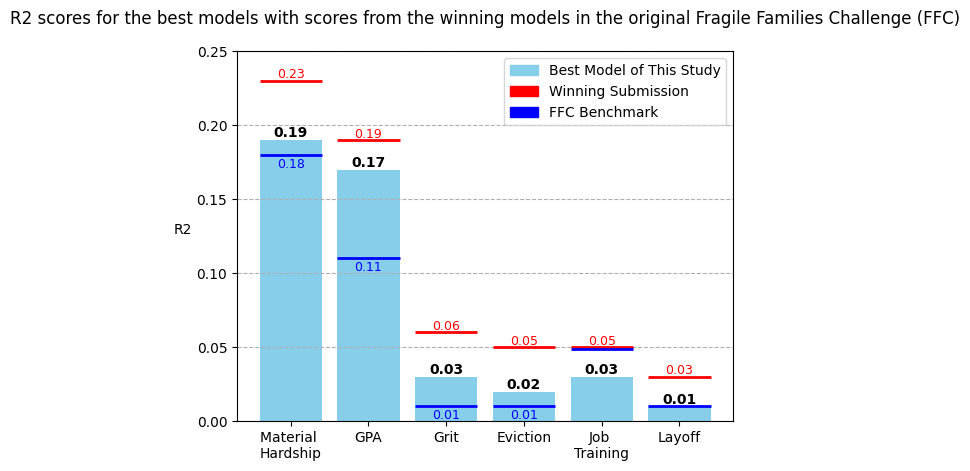

In [12]:
# Plot model results against benchmark
categories = ['Material \nHardship', 'GPA', 'Grit', 'Eviction', 'Job \nTraining', 'Layoff']

values = [0.19, 0.17, 0.03, 0.02, 0.03, 0.01]
red_line_values = [0.23, 0.19, 0.06, 0.05, 0.05, 0.03]
blue_line_values = [0.18, 0.11, 0.01, 0.01, 0.049, 0.01]

#bars = plt.bar(categories, values, color='skyblue', label='R2 Scores')
# for bar, red_line_value, blue_line_value in zip(bars, red_line_values, blue_line_values):
#     red_line = plt.hlines(red_line_value, bar.get_x(), bar.get_x() + bar.get_width(), color='red', linewidth=2, label=red_line_value)
#     blue_line = plt.hlines(blue_line_value, bar.get_x(), bar.get_x() + bar.get_width(), color='blue', linewidth=2, label=blue_line_value)

for bar, value in zip(bars, values):
    plt.text(bar.get_x() + bar.get_width() / 2, value, f'{value}', 
             ha='center', va='bottom', color='black', weight='bold')

def addlabelsWinning(x,y):
	for i in range(len(x)):
		plt.text(i, y[i]+0.002, y[i], ha = 'center', color='r', fontsize=9)

addlabelsWinning(categories, red_line_values)

def addlabelsBenchmark(x,y):
    for i in range(len(x)):
        if i < 4:
            plt.text(i, y[i]-0.0085, y[i], ha = 'center', color='blue', fontsize=9)
        else:
            continue
    
addlabelsBenchmark(categories, blue_line_values)

plt.grid(linestyle='--', axis='y')
plt.ylabel('R2', rotation=0, labelpad=10)
plt.yticks(ticks=[0.0, 0.05, 0.10, 0.15, 0.20, 0.25])
plt.title('R2 scores for the best models with scores from the winning models in the original Fragile Families Challenge (FFC)', pad=20)

model_patch = plt.Rectangle((0,0), 1, 1, color='skyblue', label='Best Model of This Study')
red_patch = plt.Rectangle((0,0), 1, 1, color='red', label='Winning Submission')
blue_patch = plt.Rectangle((0,0), 1, 1, color='blue', label='FFC Benchmark')
plt.legend(handles=[model_patch, red_patch, blue_patch])
plt.savefig('r2_plot.png', bbox_inches='tight')
plt.show()

In [21]:
# Format and report results based on optimal preprocessing steps
outcomes_reg = ['gpa', 'grit', 'materialHardship']
outcomes_clf = ['eviction', 'layoff', 'jobTraining']
model_lst = [0, 1, 2, 3, 4]
best_metaparam_model_reg = {}
best_metaparam_model_clf = {}

# Get best metaparams by model for each outcome
for o in outcomes_reg:
    best_metaparam_model_reg[o] = {}
    
    with open(data_dir+f'meta_param_res_dict_{o}.pkl', 'rb') as f:
            d_meta = pickle.load(f)

    for model_idx in model_lst:
        best_mse = 1
        
        for idx, meta_params in enumerate(meta_params_reg):
            if d_meta[idx]['model_res_dict'][model_idx]['test_mse'] < best_mse:
                best_metaparam_model_reg[o][model_idx] = meta_params
                best_mse = d_meta[idx]['model_res_dict'][model_idx]['test_mse']

for o in outcomes_clf:
    best_metaparam_model_clf[o] = {}
    
    with open(data_dir+f'meta_param_res_dict_{o}_latest.pkl', 'rb') as f:
            d_meta = pickle.load(f)

    for model_idx in model_lst:
        best_mse = 1
        
        for idx, meta_params in enumerate(meta_params_clf):
            if d_meta[idx]['model_res_dict'][model_idx]['test_mse'] < best_mse:
                best_metaparam_model_clf[o][model_idx] = meta_params
                best_mse = d_meta[idx]['model_res_dict'][model_idx]['test_mse']

In [57]:
outcome = 'gpa'
combined = pd.DataFrame(columns=['Model', 'imputation_method', 'features_selected', 'standardize'])

for k,v in model_label_dict.items():
    df = pd.DataFrame.from_dict(dict(best_metaparam_model_reg[outcome][k]), orient='index').T 
    df['Model'] = v
    df['One-Hot Encode'] = df['imputation_method'].apply(lambda x: True if x == 'simple' else False)
    combined = pd.concat([combined, df])

combined.columns = ['Model', 'Imputation Method', 'Feature Selection', 'Standardize X', 'One-Hot Encode']
ret_gpa = combined.merge(model_eval_results['gpa'], how='left', left_on='Model', right_on='Model').sort_values(by='Out-of-Sample R2', ascending=False)
ret_gpa = ret_gpa[['Model', 'Imputation Method', 'Feature Selection', 'Standardize X', 'One-Hot Encode', 'Out-of-Sample MSE', 'Out-of-Sample R2']]
display(ret_gpa)
print(ret_gpa.to_latex(index=False))

,Model,Imputation Method,Feature Selection,Standardize X,One-Hot Encode,Out-of-Sample MSE,Out-of-Sample R2
4,Gradient-Boosted Tree,simple,mi_best_1000,True,True,0.35,0.17
3,Random Forest,knn,mi_best_1000,False,False,0.36,0.16
1,Elastic Net,simple,lasso,True,True,0.40,0.06
0,Lasso,simple,mi_best_1000,True,True,0.40,0.06
2,Support Vector Machine,simple,lasso,True,True,0.42,0.01


\begin{tabular}{lllllrr}
\toprule
Model & Imputation Method & Feature Selection & Standardize X & One-Hot Encode & Out-of-Sample MSE & Out-of-Sample R2 \\
\midrule
Gradient-Boosted Tree & simple & mi_best_1000 & True & True & 0.353539 & 0.168435 \\
Random Forest & knn & mi_best_1000 & False & False & 0.355425 & 0.164000 \\
Elastic Net & simple & lasso & True & True & 0.397650 & 0.064681 \\
Lasso & simple & mi_best_1000 & True & True & 0.399409 & 0.060542 \\
Support Vector Machine & simple & lasso & True & True & 0.422394 & 0.006479 \\
\bottomrule
\end{tabular}



In [22]:
outcome = 'grit'
combined = pd.DataFrame(columns=['Model', 'imputation_method', 'features_selected', 'standardize'])

for k,v in model_label_dict.items():
    df = pd.DataFrame.from_dict(dict(best_metaparam_model_reg[outcome][k]), orient='index').T 
    df['Model'] = v
    df['One-Hot Encode'] = df['imputation_method'].apply(lambda x: True if x == 'simple' else False)
    combined = pd.concat([combined, df])

combined.columns = ['Model', 'Imputation Method', 'Feature Selection', 'Standardize X', 'One-Hot Encode']
ret_grit = combined.merge(model_eval_results[outcome], how='left', left_on='Model', right_on='Model').sort_values(by='Out-of-Sample R2', ascending=False)
ret_grit = ret_grit[['Model', 'Imputation Method', 'Feature Selection', 'Standardize X', 'One-Hot Encode', 'Out-of-Sample MSE', 'Out-of-Sample R2']]
ret_grit.columns = ['Model', 'Imputation', 'Feature Selection', 'Standardize', 'One-Hot Encode', 'MSE', 'R2']
display(ret_grit)
print(ret_grit.to_latex(index=False))

,Model,Imputation,Feature Selection,Standardize,One-Hot Encode,MSE,R2
3,Random Forest,knn,mi_best_500,True,False,0.25,0.03
4,Gradient-Boosted Tree,simple,mi_best_1000,True,True,0.25,0.02
0,Lasso,knn,mi_best_100,False,False,0.26,-0.04
1,Elastic Net,simple,mi_best_1000,True,True,0.27,-0.05
2,Support Vector Machine,knn,mi_best_500,True,False,0.28,-0.11


\begin{tabular}{lllllrr}
\toprule
Model & Imputation & Feature Selection & Standardize & One-Hot Encode & MSE & R2 \\
\midrule
Random Forest & knn & mi_best_500 & True & False & 0.246375 & 0.026121 \\
Gradient-Boosted Tree & simple & mi_best_1000 & True & True & 0.247070 & 0.023375 \\
Lasso & knn & mi_best_100 & False & False & 0.264172 & -0.044226 \\
Elastic Net & simple & mi_best_1000 & True & True & 0.265449 & -0.049272 \\
Support Vector Machine & knn & mi_best_500 & True & False & 0.281856 & -0.114129 \\
\bottomrule
\end{tabular}



In [75]:
outcome = 'materialHardship'
combined = pd.DataFrame(columns=['Model', 'imputation_method', 'features_selected', 'standardize'])

for k,v in model_label_dict.items():
    df = pd.DataFrame.from_dict(dict(best_metaparam_model_reg[outcome][k]), orient='index').T 
    df['Model'] = v
    df['One-Hot Encode'] = df['imputation_method'].apply(lambda x: True if x == 'simple' else False)
    combined = pd.concat([combined, df])

combined.columns = ['Model', 'Imputation Method', 'Feature Selection', 'Standardize X', 'One-Hot Encode']
ret_material = combined.merge(model_eval_results[outcome], how='left', left_on='Model', right_on='Model').sort_values(by='Out-of-Sample R2', ascending=False)
ret_material = ret_material[['Model', 'Imputation Method', 'Feature Selection', 'Standardize X', 'One-Hot Encode', 'Out-of-Sample MSE', 'Out-of-Sample R2']]
display
print(ret_material.to_latex(index=False))

\begin{tabular}{lllllrr}
\toprule
Model & Imputation Method & Feature Selection & Standardize X & One-Hot Encode & Out-of-Sample MSE & Out-of-Sample R2 \\
\midrule
Gradient-Boosted Tree & simple & mi_best_500 & True & True & 0.020057 & 0.194681 \\
Random Forest & simple & mi_best_500 & True & True & 0.020502 & 0.176806 \\
Lasso & simple & mi_best_500 & False & True & 0.024725 & 0.007251 \\
Elastic Net & simple & mi_best_500 & False & True & 0.024765 & 0.005638 \\
Support Vector Machine & simple & mi_best_250 & True & True & 0.025720 & -0.032699 \\
\bottomrule
\end{tabular}



In [81]:
outcome = 'eviction'
combined = pd.DataFrame(columns=['Model', 'imputation_method', 'features_selected', 'standardize', 'resampling'])

for k,v in model_label_dict.items():
    df = pd.DataFrame.from_dict(dict(best_metaparam_model_clf[outcome][k]), orient='index').T 
    df['Model'] = v
    df['One-Hot Encode'] = df['imputation_method'].apply(lambda x: True if x == 'simple' else False)
    combined = pd.concat([combined, df])

combined.columns = ['Model', 'Imputation Method', 'Feature Selection', 'Standardize X', 'Resampling', 'One-Hot Encode']
ret_eviction = combined.merge(model_eval_results[outcome], how='left', left_on='Model', right_on='Model').sort_values(by='Out-of-Sample R2', ascending=False)
ret_eviction = ret_eviction[['Model', 'Imputation Method', 'Feature Selection', 'Standardize X', 'One-Hot Encode', 'Resampling', 'Out-of-Sample MSE', 'Out-of-Sample R2']]
display(ret_eviction)
print(ret_eviction.to_latex(index=False))

,Model,Imputation Method,Feature Selection,Standardize X,One-Hot Encode,Resampling,Out-of-Sample MSE,Out-of-Sample R2
1,Elastic Net,simple,mi_best_100,True,True,None,0.06,-0.06
3,Random Forest,simple,mi_best_1000,True,True,upsample,0.06,-0.06
2,Support Vector Machine,simple,mi_best_500,True,True,downsample,0.06,-0.06
4,Gradient-Boosted Tree,simple,mi_best_1000,True,True,upsample,0.06,-0.11
0,Lasso,simple,mi_best_100,True,True,None,0.10,-0.81


\begin{tabular}{llllllrr}
\toprule
Model & Imputation Method & Feature Selection & Standardize X & One-Hot Encode & Resampling & Out-of-Sample MSE & Out-of-Sample R2 \\
\midrule
Elastic Net & simple & mi_best_100 & True & True & NaN & 0.058930 & -0.062611 \\
Random Forest & simple & mi_best_1000 & True & True & upsample & 0.058930 & -0.062611 \\
Support Vector Machine & simple & mi_best_500 & True & True & downsample & 0.058930 & -0.062611 \\
Gradient-Boosted Tree & simple & mi_best_1000 & True & True & upsample & 0.061650 & -0.111655 \\
Lasso & simple & mi_best_100 & True & True & NaN & 0.100635 & -0.814613 \\
\bottomrule
\end{tabular}



In [78]:
outcome = 'layoff'
combined = pd.DataFrame(columns=['Model', 'imputation_method', 'features_selected', 'standardize', 'resampling'])

for k,v in model_label_dict.items():
    df = pd.DataFrame.from_dict(dict(best_metaparam_model_clf[outcome][k]), orient='index').T 
    df['Model'] = v
    df['One-Hot Encode'] = df['imputation_method'].apply(lambda x: True if x == 'simple' else False)
    combined = pd.concat([combined, df])

combined.columns = ['Model', 'Imputation Method', 'Feature Selection', 'Standardize X', 'One-Hot Encode', 'Resampling']
ret_layoff = combined.merge(model_eval_results[outcome], how='left', left_on='Model', right_on='Model').sort_values(by='Out-of-Sample R2', ascending=False)
ret_layoff = ret_layoff[['Model', 'Imputation Method', 'Feature Selection', 'Standardize X', 'One-Hot Encode', 'Resampling' ,'Out-of-Sample MSE', 'Out-of-Sample R2']]
display(ret_layoff)
print(ret_layoff.to_latex(index=False))
      

,Model,Imputation Method,Feature Selection,Standardize X,One-Hot Encode,Resampling,Out-of-Sample MSE,Out-of-Sample R2
3,Random Forest,simple,lasso,True,None,True,0.17,0.01
0,Lasso,simple,mi_best_100,True,None,True,0.17,-0.02
4,Gradient-Boosted Tree,simple,lasso,False,upsample,True,0.17,-0.04
1,Elastic Net,simple,lasso,True,None,True,0.18,-0.06
2,Support Vector Machine,simple,lasso,False,None,True,0.18,-0.08


\begin{tabular}{llllllrr}
\toprule
Model & Imputation Method & Feature Selection & Standardize X & One-Hot Encode & Resampling & Out-of-Sample MSE & Out-of-Sample R2 \\
\midrule
Random Forest & simple & lasso & True & NaN & True & 0.165183 & 0.012202 \\
Lasso & simple & mi_best_100 & True & NaN & True & 0.169738 & -0.015034 \\
Gradient-Boosted Tree & simple & lasso & False & upsample & True & 0.173149 & -0.035432 \\
Elastic Net & simple & lasso & True & NaN & True & 0.177730 & -0.062829 \\
Support Vector Machine & simple & lasso & False & NaN & True & 0.181032 & -0.082575 \\
\bottomrule
\end{tabular}



In [79]:
outcome = 'jobTraining'
combined = pd.DataFrame(columns=['Model', 'imputation_method', 'features_selected', 'standardize', 'resampling'])

for k,v in model_label_dict.items():
    df = pd.DataFrame.from_dict(dict(best_metaparam_model_clf[outcome][k]), orient='index').T 
    df['Model'] = v
    df['One-Hot Encode'] = df['imputation_method'].apply(lambda x: True if x == 'simple' else False)
    combined = pd.concat([combined, df])

combined.columns = ['Model', 'Imputation Method', 'Feature Selection', 'Standardize X', 'One-Hot Encode', 'Resampling']
ret_jobTraining = combined.merge(model_eval_results[outcome], how='left', left_on='Model', right_on='Model').sort_values(by='Out-of-Sample R2', ascending=False)
ret_jobTraining = ret_jobTraining[['Model', 'Imputation Method', 'Feature Selection', 'Standardize X', 'One-Hot Encode', 'Resampling' ,'Out-of-Sample MSE', 'Out-of-Sample R2']]
display(ret_jobTraining)
print(ret_jobTraining.to_latex(index=False))

,Model,Imputation Method,Feature Selection,Standardize X,One-Hot Encode,Resampling,Out-of-Sample MSE,Out-of-Sample R2
3,Random Forest,simple,mi_best_500,True,None,True,0.18,0.03
4,Gradient-Boosted Tree,simple,mi_best_100,True,None,True,0.19,0.00
0,Lasso,simple,mi_best_100,False,None,True,0.19,-0.02
1,Elastic Net,knn,mi_best_100,True,None,False,0.19,-0.05
2,Support Vector Machine,simple,mi_best_500,True,upsample,True,0.21,-0.13


\begin{tabular}{llllllrr}
\toprule
Model & Imputation Method & Feature Selection & Standardize X & One-Hot Encode & Resampling & Out-of-Sample MSE & Out-of-Sample R2 \\
\midrule
Random Forest & simple & mi_best_500 & True & NaN & True & 0.180498 & 0.026072 \\
Gradient-Boosted Tree & simple & mi_best_100 & True & NaN & True & 0.185040 & 0.001561 \\
Lasso & simple & mi_best_100 & False & NaN & True & 0.188541 & -0.017331 \\
Elastic Net & knn & mi_best_100 & True & NaN & False & 0.194632 & -0.050193 \\
Support Vector Machine & simple & mi_best_500 & True & upsample & True & 0.209451 & -0.130153 \\
\bottomrule
\end{tabular}



## Stage 6: Interpretability Analysis

In [9]:
# define helper functions
def jaccard_score(A: set, B: set):
    '''
    Given two sets, A and B, compute the jaccard similarity score between the sets.
    '''
    intersection = A.intersection(B)
    union = A.union(B) 
    score = len(intersection) / len(union)
    return score

In [8]:
# Load metadata for each feature from metadata file
metadata = pd.read_csv(data_dir+'FFMetadata_v13_UTF.csv')
cols = ['new_name', 'varlab', 'topics', 'subtopics' , 'group', 'wave', 'respondent']
features_meta = metadata[cols]

features_meta['topics_lst'] = features_meta['topics'].apply(lambda x: x.split(' ; '))
var_topic = features_meta[['new_name', 'varlab', 'topics_lst', 'subtopics', 'wave', 'respondent']]
var_topic.columns = ['variable', 'label', 'topic', 'subtopics', 'wave', 'respondent']
var_dict = var_topic.set_index('variable').to_dict(orient='index')

/tmp/ipykernel_322602/1719323994.py:2: DtypeWarning: Columns (12,23,24,27,99,103,107,111,115,119,123,127,131,135,139,143,147,151) have mixed types. Specify dtype option on import or set low_memory=False.
  metadata = pd.read_csv(data_dir+'FFMetadata_v13_UTF.csv')
/tmp/ipykernel_322602/1719323994.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  features_meta['topics_lst'] = features_meta['topics'].apply(lambda x: x.split(' ; '))


### Stage 6.2: Analysis of Common Predictors for GPA and Grit

In [52]:
# Common predictors of Grit and GPA from Lasso feature selection and Mutual Information
gpa_features_mi = set(mi_best_k_dict_source['gpa'][1000]) # k=2000 since this is the best k for gpa
gpa_features_lasso = set(lasso_features_dict_source['gpa']['features'])

grit_features_mi = set(mi_best_k_dict_source['grit'][1000]) # k=2000 since this is the best k for grit
grit_features_lasso = set(lasso_features_dict_source['grit']['features'])


In [11]:
with open(data_dir+'global_best_dict_gpa.pkl', 'rb') as f:
    dict_gpa =  pickle.load(f)

with open(data_dir+'global_best_dict_grit.pkl', 'rb') as f:
    dict_grit =  pickle.load(f)

# Tranfrom out-of-sample X based on previously identified best metaparams and models for GPA
X_gpa, y_gpa = feature_transform_metaparams('gpa', dict_gpa['best_metaparams'], out_sample, x_out_sample_simple, x_out_sample_knn,
                                    imputation_method_dict, return_y_train=False)
X_grit, y_grit = feature_transform_metaparams('grit', dict_grit['best_metaparams'], out_sample, x_out_sample_simple, x_out_sample_knn,
                                    imputation_method_dict, return_y_train=False)


In [13]:
model_rf_gpa = dict_gpa['best_model_res_dict'][3]['model'].best_estimator_[0]
explainer_rf_gpa = shap.TreeExplainer(model_rf_gpa, X_gpa) 
shap_values_rf_gpa = explainer_rf_gpa(X_gpa)

model_xgb_gpa = dict_gpa['best_model_res_dict'][4]['model'].best_estimator_[0]
explainer_xgb_gpa = shap.TreeExplainer(model_xgb_gpa, X_gpa) 
shap_values_xgb_gpa = explainer_xgb_gpa(X_gpa)

 99%|===================| 879/886 [00:17<00:00]        

In [15]:
# Tranfrom out-of-sample X based on best metaparams and models for Grit
X_grit, y_grit= feature_transform_metaparams('grit', dict_grit['best_metaparams'], out_sample, x_out_sample_simple, x_out_sample_knn,
                                    imputation_method_dict, return_y_train=False)

model_rf_grit = dict_grit['best_model_res_dict'][3]['model'].best_estimator_[0]
explainer_rf_grit = shap.TreeExplainer(model_rf_grit, X_grit) 
shap_values_rf_grit = explainer_rf_grit(X_grit)

model_xgb_grit = dict_grit['best_model_res_dict'][4]['model'].best_estimator_[0]
explainer_xgb_grit = shap.TreeExplainer(model_xgb_grit, X_grit) 
shap_values_xgb_grit = explainer_xgb_grit(X_grit)

 99%|===================| 1069/1075 [00:33<00:00]        

In [16]:
vals_gpa_rf = explainer_rf_gpa.shap_values(X_gpa)
vals_grit_rf = explainer_rf_grit.shap_values(X_grit)
shap_avg_gpa_rf = np.mean(np.abs(vals_gpa_rf), axis=0)
shap_avg_grit_rf = np.mean(np.abs(vals_grit_rf), axis=0)
print(f'Number of Random Forest GPA Predictors with non-zero SHAP values: {np.count_nonzero(shap_avg_gpa_rf)} ({round(np.count_nonzero(shap_avg_gpa_rf)/2000 *100,2)})%')
print(f'Number of Random Forest Grit Predictors with non-zero SHAP values: {np.count_nonzero(shap_avg_grit_rf)} ({round(np.count_nonzero(shap_avg_grit_rf)/2000*100, 2)})%')

vals_gpa_xgb = explainer_xgb_gpa.shap_values(X_gpa)
vals_grit_xgb = explainer_xgb_grit.shap_values(X_grit)
shap_avg_gpa_xgb = np.mean(np.abs(vals_gpa_xgb), axis=0)
shap_avg_grit_xgb = np.mean(np.abs(vals_grit_xgb),axis=0)
print(f'Number of Gradient-Boosted Tree GPA Predictors with non-zero SHAP values: {np.count_nonzero(shap_avg_gpa_xgb)} ({round(np.count_nonzero(shap_avg_gpa_xgb) / 2000,2)*100 }%)')
print(f'Number of Gradient-Boosted Tree Grit Predictors with non-zero SHAP values: {np.count_nonzero(shap_avg_grit_xgb)} ({round(np.count_nonzero(shap_avg_grit_xgb)/2000*100, 2)})%')

# Get feature with non-zero SHAP values based on each model
feature_gpa = list(X_gpa.columns)
feature_grit = list(X_grit.columns)

gpa_set_rf = set([feature_gpa[int(i)] for i in np.nonzero(shap_avg_gpa_rf)[0]])
grit_set_rf = set([feature_grit[int(i)] for i in np.nonzero(shap_avg_grit_rf)[0]])
gpa_set_xgb = set([feature_gpa[int(i)] for i in np.nonzero(shap_avg_gpa_xgb)[0]])
grit_set_xgb = set([feature_grit[int(i)] for i in np.nonzero(shap_avg_grit_xgb)[0]])

 97%|=================== | 1042/1075 [00:19<00:00]       

Number of Random Forest GPA Predictors with non-zero SHAP values: 1726 (86.3)%
Number of Random Forest Grit Predictors with non-zero SHAP values: 1600 (80.0)%


 98%|===================| 1053/1075 [00:33<00:00]        

Number of Gradient-Boosted Tree GPA Predictors with non-zero SHAP values: 375 (19.0%)
Number of Gradient-Boosted Tree Grit Predictors with non-zero SHAP values: 1740 (87.0)%


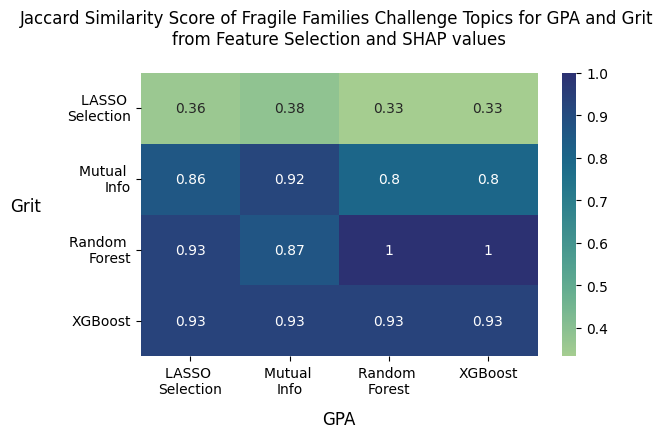

In [113]:
def unnest_lst(lst): 
        '''
        Helper function to unnest Python list for output formatting 
        '''
        ret = set([x for lst2 in lst for x in lst2 ])
        return ret

title = 'Jaccard Similarity Score of Fragile Families Challenge Topics for GPA and Grit \nfrom Feature Selection and SHAP values\n'
plt.ylabel('Grit')
plt.xlabel('GPA')
xticklabels = ['LASSO \nSelection', 'Mutual \nInfo', 'Random \nForest', 'XGBoost']
yticklabels = xticklabels

gpa_topics_lasso = unnest_lst([var_dict[v]['topic'] if v in var_dict else ['Unknown'] for v in gpa_features_lasso ])
gpa_topics_mi = unnest_lst([var_dict[v]['topic'] if v in var_dict else ['Unknown'] for v in gpa_features_mi ])
gpa_topics_rf = unnest_lst([var_dict[v]['topic'] if v in var_dict else ['Unknown'] for v in gpa_set_rf ])
gpa_topics_xgb = unnest_lst([var_dict[v]['topic'] if v in var_dict else ['Unknown'] for v in gpa_set_xgb ])
grit_topics_lasso = unnest_lst([var_dict[v]['topic'] if v in var_dict else ['Unknown'] for v in grit_features_lasso ])
grit_topics_mi = unnest_lst([var_dict[v]['topic'] if v in var_dict else ['Unknown'] for v in grit_features_mi ])
grit_topics_rf = unnest_lst([var_dict[v]['topic'] if v in var_dict else ['Unknown'] for v in grit_set_rf ])
grit_topics_xgb = unnest_lst([var_dict[v]['topic'] if v in var_dict else ['Unknown'] for v in grit_set_xgb ])

lst = [ 
        [ jaccard_score(gpa_topics_lasso, grit_topics_lasso), jaccard_score(gpa_topics_mi, grit_topics_lasso), jaccard_score(gpa_topics_rf, grit_topics_lasso), jaccard_score(gpa_topics_xgb, grit_topics_lasso) ],
        [ jaccard_score(gpa_topics_lasso, grit_topics_mi), jaccard_score(gpa_topics_mi, grit_topics_mi), jaccard_score(gpa_topics_rf, grit_topics_mi), jaccard_score(gpa_topics_xgb, grit_topics_mi) ],
        [ jaccard_score(gpa_topics_lasso, grit_topics_rf), jaccard_score(gpa_topics_mi, grit_topics_rf), jaccard_score(gpa_topics_rf, grit_topics_rf), jaccard_score(gpa_topics_xgb, grit_topics_rf) ],
        [ jaccard_score(gpa_topics_lasso, grit_topics_xgb), jaccard_score(gpa_topics_lasso, grit_topics_xgb), jaccard_score(gpa_topics_lasso, grit_topics_xgb), jaccard_score(gpa_topics_lasso, grit_topics_xgb) ] 
        
]

# Jaccard Similarity Score of Features Selected for GPA and Grit by LASSO and Mutual Information
ax = sns.heatmap(lst, cmap='crest', annot=True)
ax.set(title = title)
ax.set_ylabel(ylabel='Grit', rotation=0, labelpad=30, fontdict={'size': 12})
ax.set_xlabel(xlabel='GPA', rotation=0, labelpad=10, fontdict={'size': 12})
ax.set_xticklabels(labels=xticklabels, rotation=0)
ax.set_yticklabels(labels=yticklabels, rotation=0)

plt.subplots_adjust(top=0.7)
plt.savefig(out_dir +"jaccard_topics.png".format(title), bbox_inches='tight')
plt.show()

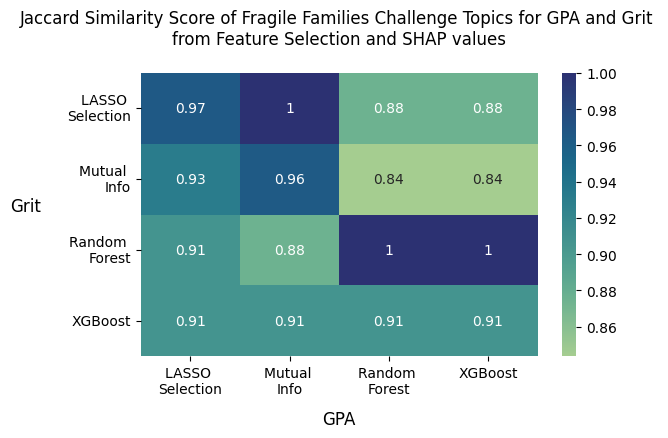

In [55]:
def unnest_lst(lst): 
        '''
        Helper function to unnest Python list for output formatting 
        '''
        ret = set([x for lst2 in lst for x in lst2 ])
        return ret

title = 'Jaccard Similarity Score of Fragile Families Challenge Topics for GPA and Grit \nfrom Feature Selection and SHAP values\n'
plt.ylabel('Grit')
plt.xlabel('GPA')
xticklabels = ['LASSO \nSelection', 'Mutual \nInfo', 'Random \nForest', 'XGBoost']
yticklabels = xticklabels

gpa_topics_lasso = unnest_lst([var_dict[v]['subtopics'] if v in var_dict else ['Unknown'] for v in gpa_features_lasso ])
gpa_topics_mi = unnest_lst([var_dict[v]['subtopics'] if v in var_dict else ['Unknown'] for v in gpa_features_mi ])
gpa_topics_rf = unnest_lst([var_dict[v]['subtopics'] if v in var_dict else ['Unknown'] for v in gpa_set_rf ])
gpa_topics_xgb = unnest_lst([var_dict[v]['subtopics'] if v in var_dict else ['Unknown'] for v in gpa_set_xgb ])
grit_topics_lasso = unnest_lst([var_dict[v]['subtopics'] if v in var_dict else ['Unknown'] for v in grit_features_lasso ])
grit_topics_mi = unnest_lst([var_dict[v]['subtopics'] if v in var_dict else ['Unknown'] for v in grit_features_mi ])
grit_topics_rf = unnest_lst([var_dict[v]['subtopics'] if v in var_dict else ['Unknown'] for v in grit_set_rf ])
grit_topics_xgb = unnest_lst([var_dict[v]['subtopics'] if v in var_dict else ['Unknown'] for v in grit_set_xgb ])

lst = [ 
        [ jaccard_score(gpa_topics_lasso, grit_topics_lasso), jaccard_score(gpa_topics_mi, grit_topics_lasso), jaccard_score(gpa_topics_rf, grit_topics_lasso), jaccard_score(gpa_topics_xgb, grit_topics_lasso) ],
        [ jaccard_score(gpa_topics_lasso, grit_topics_mi), jaccard_score(gpa_topics_mi, grit_topics_mi), jaccard_score(gpa_topics_rf, grit_topics_mi), jaccard_score(gpa_topics_xgb, grit_topics_mi) ],
        [ jaccard_score(gpa_topics_lasso, grit_topics_rf), jaccard_score(gpa_topics_mi, grit_topics_rf), jaccard_score(gpa_topics_rf, grit_topics_rf), jaccard_score(gpa_topics_xgb, grit_topics_rf) ],
        [ jaccard_score(gpa_topics_lasso, grit_topics_xgb), jaccard_score(gpa_topics_lasso, grit_topics_xgb), jaccard_score(gpa_topics_lasso, grit_topics_xgb), jaccard_score(gpa_topics_lasso, grit_topics_xgb) ] 
        
]

# Jaccard Similarity Score of Features Selected for GPA and Grit by LASSO and Mutual Information
ax = sns.heatmap(lst, cmap='crest', annot=True)
ax.set(title = title)
ax.set_ylabel(ylabel='Grit', rotation=0, labelpad=30, fontdict={'size': 12})
ax.set_xlabel(xlabel='GPA', rotation=0, labelpad=10, fontdict={'size': 12})
ax.set_xticklabels(labels=xticklabels, rotation=0)
ax.set_yticklabels(labels=yticklabels, rotation=0)

plt.subplots_adjust(top=0.7)
plt.savefig(out_dir +"jaccard_topics.png".format(title), bbox_inches='tight')
plt.show()

### Stage 6.2 Predict GPA with the best model and selected features of Grit, and vice versa 

In [46]:
# Predict GPA with predictors of Grit
outcome = 'gpa'
pipelines = [ pipe_rf_reg, pipe_xgb_reg ]
hyperparams = [ hyper_rf, hyper_xgb ]
features_selected_dict_knn['best_features_grit_gpa'] = {} 
features_selected_dict_knn['best_features_grit_gpa'][outcome] = gpa_set_rf.intersection(grit_set_xgb)
metaparams_gpa_grit = [(('imputation_method', 'knn'), 
                        ('features_selected', 'best_features_grit_gpa'),
                        ('standardize', True) )]

predict_gpa_w_common, res_dict, errors_log = trainModelsMeta(outcome, metaparams_gpa_grit, pipelines, hyperparams, imputation_method_dict, features)

outcome = 'grit'
features_selected_dict_knn['best_features_grit_gpa'][outcome] = gpa_set_rf.intersection(grit_set_xgb)
metaparams_grit_gpa = [(('imputation_method', 'knn'), ('features_selected', 'best_features_grit_gpa'),
    ('standardize', True) )]

predict_grit_w_common, res_dict, errors_log = trainModelsMeta(outcome, metaparams_grit_gpa, pipelines, hyperparams, imputation_method_dict, features)

Training on metaparams #1 of 1
Training on metaparams #1 of 1


In [47]:
outcomes = ['gpa', 'grit']
d = {
    'gpa': predict_gpa_w_common,
    'grit': predict_grit_w_common
}

model_label_dict = {
    0: 'Random Forest',
    1: 'XGBoost'
}

df_ret = {}

for outcome in outcomes:
    estimator_rf = d[outcome]['best_model_res_dict'][0]['model'].best_estimator_
    estimator_xgb = d[outcome]['best_model_res_dict'][1]['model'].best_estimator_
    estimator_lst = [ estimator_rf, estimator_xgb ]

    meta_params = dict(metaparams_gpa_grit[0]) if outcome=='gpa' else dict(metaparams_grit_gpa[0])
    x_out_sample, y_out_sample, y_train = feature_transform_metaparams(outcome, meta_params, out_sample, x_out_sample_simple, x_out_sample_knn, 
                                                                        imputation_method_dict, return_y_train=True)
    model_name  = []
    mse_in_sample = []
    r2_in_sample = [] 
    mse_out_sample = []
    r2_out_sample = []

    for idx, model in enumerate(estimator_lst):    
        y_pred = model.predict(x_out_sample)
        model_name.append(model_label_dict[idx])
        mse_out_sample.append(mean_squared_error(y_out_sample, y_pred))
        r2_out_sample.append(r2_holdout_score(y_out_sample, y_pred, y_train))
        mse_in_sample.append(d[outcome]['best_model_res_dict'][idx]['test_mse'])
        r2_in_sample.append(d[outcome]['best_model_res_dict'][idx]['r2_holdout'])
        
    df_ret[outcome] = pd.DataFrame.from_dict({
        'Model': model_name, 
        'In-Sample Test MSE': mse_in_sample,
        'In-Sample Test R2': r2_in_sample,
        'Out-of-Sample MSE': mse_out_sample,
        'Out-of-Sample R2': r2_out_sample,
    })     
    
predict_gpa_w_common_res = df_ret['gpa'].sort_values(by='Out-of-Sample R2', ascending=False)
predict_grit_w_common_res = df_ret['grit'].sort_values(by='Out-of-Sample R2', ascending=False)

In [48]:
# Results of Predicting GPA and Grit based on the Common Feature Set (intersection) of both outcomes 
print("Results of Predicting GPA and Grit based on the Common Feature Set (intersection) of both outcomes:\n")
display(predict_gpa_w_common_res)
print(predict_gpa_w_common_res.to_latex(index=False))

display(predict_grit_w_common_res)
print(predict_grit_w_common_res.to_latex(index=False))

Results of Predicting GPA and Grit based on the Common Feature Set (intersection) of both outcomes:



,Model,In-Sample Test MSE,In-Sample Test R2,Out-of-Sample MSE,Out-of-Sample R2
0,Random Forest,0.40,0.16,0.36,0.14
1,XGBoost,0.40,0.17,0.37,0.14


\begin{tabular}{lrrrr}
\toprule
Model & In-Sample Test MSE & In-Sample Test R2 & Out-of-Sample MSE & Out-of-Sample R2 \\
\midrule
Random Forest & 0.402047 & 0.162699 & 0.364805 & 0.141935 \\
XGBoost & 0.400767 & 0.165363 & 0.366098 & 0.138895 \\
\bottomrule
\end{tabular}



,Model,In-Sample Test MSE,In-Sample Test R2,Out-of-Sample MSE,Out-of-Sample R2
1,XGBoost,0.23,0.01,0.25,0.02
0,Random Forest,0.23,0.01,0.25,0.01


\begin{tabular}{lrrrr}
\toprule
Model & In-Sample Test MSE & In-Sample Test R2 & Out-of-Sample MSE & Out-of-Sample R2 \\
\midrule
XGBoost & 0.229259 & 0.010232 & 0.248591 & 0.017364 \\
Random Forest & 0.228885 & 0.011848 & 0.249513 & 0.013717 \\
\bottomrule
\end{tabular}



In [97]:
#Print most important questions for GPA and Grit 

features_gpa_grit = gpa_set_rf.intersection(grit_set_xgb)
d_shap = {}

for f in features_gpa_grit:
    gpa_shap = 0
    grit_shap = 0
    for i, f_gpa in enumerate(feature_gpa):
        if f_gpa == f:
            gpa_shap = shap_avg_gpa_rf[i]
    for j, f_grit in enumerate(feature_grit):
        if f_grit == f:
            grit_shap = shap_avg_grit_xgb[j]
    
    #d_shap[f] = max(gpa_shap, grit_shap)
    d_shap[f] = (gpa_shap * (0.17/0.2))+ (grit_shap* (0.03/0.2))

print(len(d_shap.keys()) == len(features_gpa_grit))

True


In [136]:
shap_df = pd.DataFrame.from_dict(d_shap, orient='index', columns=['Mean Absolute SHAP']).sort_values(by='Mean Absolute SHAP', ascending=False)
shap_df['Mean Absolute SHAP (Normalised)'] = (shap_df['Mean Absolute SHAP'] - shap_df['Mean Absolute SHAP'].min()) / (shap_df['Mean Absolute SHAP'].max() - shap_df['Mean Absolute SHAP'].min())
df_ret_shap = shap_df[shap_df['Mean Absolute SHAP (Normalised)'] > 0][['Mean Absolute SHAP (Normalised)']]
df_ret_shap.reset_index(inplace=True)
df_ret_shap.columns = ['variable', 'SHAP Value']

df_ret_shap = df_ret_shap.merge(var_topic, how="left", left_on='variable', right_on='variable').sort_values('SHAP Value', ascending=False)
df_ret_shap.set_index('variable', inplace=True)
out = df_ret_shap[['SHAP Value', 'label', 'subtopics', 'wave', 'respondent']]
out.columns = ['SHAP Value', 'Question', 'SubTopics', 'Wave', 'Respondent']
print('Most Important Common Family Background Predictors of GPA and Grit:')
display(out[['Question', 'SubTopics', 'Wave', 'Respondent']].head(10))
print(out[['Question', 'SubTopics', 'Wave', 'Respondent']].head(10).to_latex(index=False))


Most Important Common Family Background Predictors of GPA and Grit:


,Question,SubTopics,Wave,Respondent
variable,,,,
t5b1l,B1L. Child uses time appropriately while waiti...,behavior,Year 9,Teacher
cf1edu,Constructed - Father baseline education (fathe...,educational attainment/achievement,Baseline,Father
m2g6d1,Could you count on someone to co-sign for a lo...,social support,Year 1,Mother
m1i1,What is the highest grade/years of school that...,educational attainment/achievement,Baseline,Mother
cp3food_exp,Constructed - Monthly total food expenses,expenses,Year 3,Primary Caregiver
m5j1,J1. Total household income before taxes/deduct...,household income/poverty,Year 9,Mother
cm2hhinc,Constructed - Household income (with imputed v...,household income/poverty,Year 1,Mother
f3k12,What do/did you do at this/that job?,employment - traditional work,Year 3,Father
ch3att_b3,sociability,behavior,Year 3,Primary Caregiver


\begin{tabular}{llll}
\toprule
Question & SubTopics & Wave & Respondent \\
\midrule
B1L. Child uses time appropriately while waiting for help & behavior & Year 9 & Teacher \\
Constructed - Father baseline education (father report, then mother report) & educational attainment/achievement & Baseline & Father \\
Could you count on someone to co-sign for a loan for $5000? & social support & Year 1 & Mother \\
What is the highest grade/years of school that you have completed? & educational attainment/achievement & Baseline & Mother \\
Constructed - Monthly total food expenses & expenses & Year 3 & Primary Caregiver \\
J1. Total household income before taxes/deductions in past 12 months & household income/poverty & Year 9 & Mother \\
Constructed - Household income (with imputed values) & household income/poverty & Year 1 & Mother \\
What do/did you do at this/that job? & employment - traditional work & Year 3 & Father \\
sociability & behavior & Year 3 & Primary Caregiver \\
G35. Age when yo

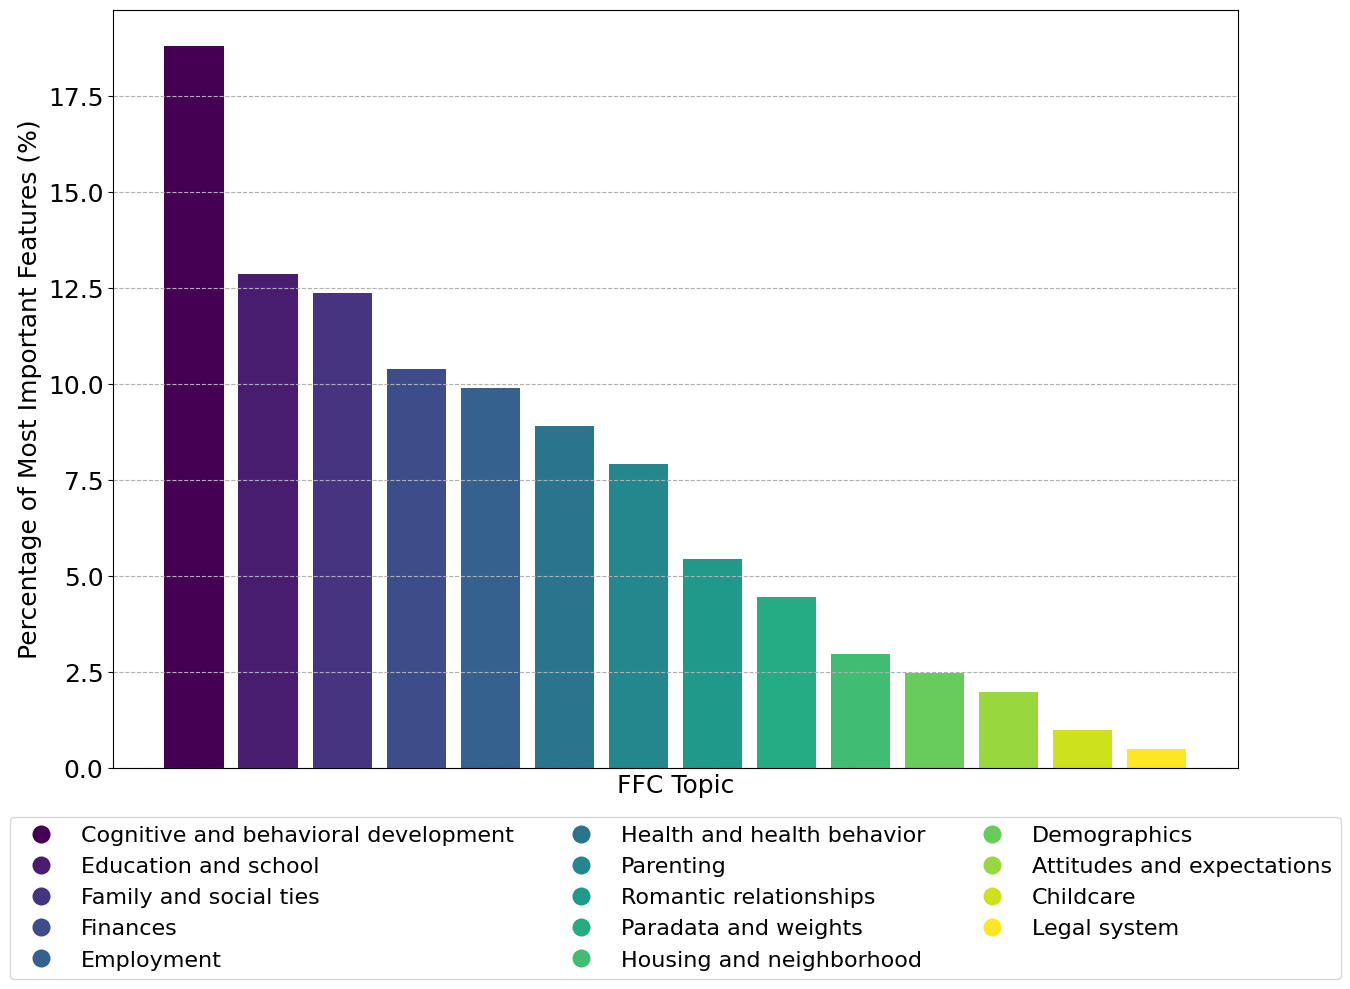

In [161]:
out = df_ret_shap[['SHAP Value', 'topic']]
out = out.explode('topic')
topic_counts = out['topic'].value_counts(normalize=True)
topics = list(out['topic'].dropna().unique())
frequencies = [x*100 for x in list(topic_counts.values)]

# Define a consistent color scheme with 14 different colors
colors = plt.cm.viridis(np.linspace(0, 1, 14))
plt.figure(figsize=(14, 10))
bars = plt.bar(topics, frequencies, color=colors)
legend_patches = [plt.Line2D([0], [0], marker='o', color='w', label=topics[i], 
                             markersize=14, markerfacecolor=colors[i]) for i in range(14)]
plt.legend(handles=legend_patches, loc='upper center', bbox_to_anchor=(0.5, -0.05), fontsize=16, ncol=3, fancybox=True)
plt.xlabel('FFC Topic', fontsize=18)
plt.ylabel('Percentage of Most Important Features (%)', fontsize=18)
plt.xticks([])
plt.yticks(fontsize=18)
plt.grid(linestyle='--', axis='y')
# Show the plot

plt.tight_layout()
plt.savefig(out_dir+'topics_shap_barplot', bbox_inches='tight')
plt.show()


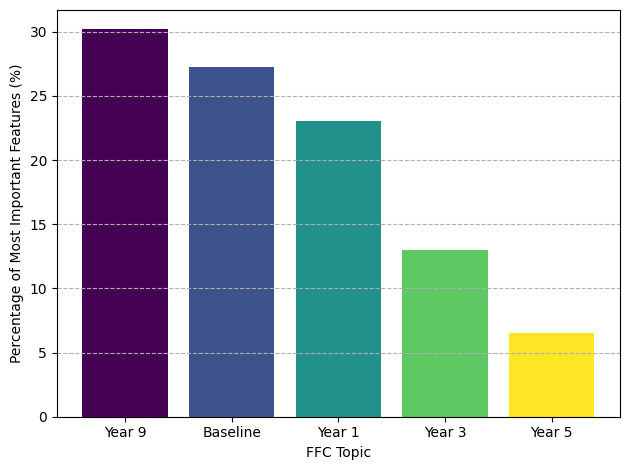

In [177]:
out = df_ret_shap[['SHAP Value', 'wave']]
out = out.explode('wave')
topic_counts = out['wave'].value_counts(normalize=True)
topics = list(out['wave'].dropna().unique())
frequencies = [x*100 for x in list(topic_counts.values)]

# Define a consistent color scheme with 14 different colors
colors = plt.cm.viridis(np.linspace(0, 1, 5))
bars = plt.bar(topics, frequencies, color=colors)
plt.xlabel('FFC Topic', fontsize=10)
plt.ylabel('Percentage of Most Important Features (%)', fontsize=10)
plt.grid(linestyle='--', axis='y')
# Show the plot

plt.tight_layout()
plt.savefig(out_dir+'wave_shap_barplot', bbox_inches='tight')
plt.show()


In [76]:
#Print most important questions for GPA
d_shap = {}

for f in gpa_set_rf:
    for i, f_gpa in enumerate(feature_gpa):
        if f_gpa == f:
            d_shap[f] = shap_avg_gpa_rf[i]

shap_df = pd.DataFrame.from_dict(d_shap, orient='index', columns=['Mean Absolute SHAP']).sort_values(by='Mean Absolute SHAP', ascending=False)
shap_df['Mean Absolute SHAP (Normalised)'] = (shap_df['Mean Absolute SHAP'] - shap_df['Mean Absolute SHAP'].min()) / (shap_df['Mean Absolute SHAP'].max() - shap_df['Mean Absolute SHAP'].min())
df_ret = shap_df[shap_df['Mean Absolute SHAP (Normalised)'] > 0][['Mean Absolute SHAP (Normalised)']]
df_ret.reset_index(inplace=True)
df_ret.columns = ['variable', 'SHAP Value']

df_ret = df_ret.merge(var_topic, how="left", left_on='variable', right_on='variable').sort_values('SHAP Value', ascending=False)
df_ret.set_index('variable', inplace=True)
out = df_ret[['SHAP Value', 'label', 'subtopics', 'wave', 'respondent']]
out.columns = ['SHAP Value', 'Question', 'SubTopics', 'Wave', 'Respondent']
print('Most Important Common Family Background Predictors of GPA:')
display(out[['Question', 'SubTopics', 'Wave', 'Respondent']].head(10))
print(out[['Question', 'SubTopics', 'Wave', 'Respondent']].head(10).to_latex(index=False))

Most Important Common Family Background Predictors of GPA:


,Question,SubTopics,Wave,Respondent
variable,,,,
t5c13c,c13C. Child's mathematical skills,educational attainment/achievement,Year 9,Teacher
ch5ppvtraw,PPVT raw score,cognitive skills,Year 9,Child
ch5wj10ss,Woodcock Johnson Test 10 standard score,cognitive skills,Year 9,Child
ch5ppvtss,PPVT standard score,cognitive skills,Year 9,Child
t5b1g,B1G. Child finishes class assignments with tim...,behavior,Year 9,Teacher
ch5wj10raw,Woodcock Johnson Test 10 raw score,cognitive skills,Year 9,Child
cm4povco,Constructed - Poverty ratio - mother's househo...,household income/poverty,Year 5,Mother
t5b1l,B1L. Child uses time appropriately while waiti...,behavior,Year 9,Teacher
t5b4r,B4R. Child lacks interest in schoolwork,behavior,Year 9,Teacher


\begin{tabular}{llll}
\toprule
Question & SubTopics & Wave & Respondent \\
\midrule
c13C. Child's mathematical skills & educational attainment/achievement & Year 9 & Teacher \\
PPVT raw score & cognitive skills & Year 9 & Child \\
Woodcock Johnson Test 10 standard score & cognitive skills & Year 9 & Child \\
PPVT standard score & cognitive skills & Year 9 & Child \\
B1G. Child finishes class assignments with time limits & behavior & Year 9 & Teacher \\
Woodcock Johnson Test 10 raw score & cognitive skills & Year 9 & Child \\
Constructed - Poverty ratio - mother's household income/poverty threshold & household income/poverty & Year 5 & Mother \\
B1L. Child uses time appropriately while waiting for help & behavior & Year 9 & Teacher \\
B4R. Child lacks interest in schoolwork & behavior & Year 9 & Teacher \\
Constructed - Father baseline education (father report, then mother report) & educational attainment/achievement & Baseline & Father \\
\bottomrule
\end{tabular}



In [51]:
#Print most important questions for Grit
d_shap = {}

for f in grit_set_xgb:
    for i, f_gpa in enumerate(feature_grit):
        if f_gpa == f:
            d_shap[f] = shap_avg_grit_xgb[i]

shap_df = pd.DataFrame.from_dict(d_shap, orient='index', columns=['Mean Absolute SHAP']).sort_values(by='Mean Absolute SHAP', ascending=False)
shap_df['Mean Absolute SHAP (Normalised)'] = (shap_df['Mean Absolute SHAP'] - shap_df['Mean Absolute SHAP'].min()) / (shap_df['Mean Absolute SHAP'].max() - shap_df['Mean Absolute SHAP'].min())
df_ret = shap_df[shap_df['Mean Absolute SHAP (Normalised)'] > 0][['Mean Absolute SHAP (Normalised)']]
df_ret.reset_index(inplace=True)
df_ret.columns = ['variable', 'SHAP Value']

df_ret = df_ret.merge(var_topic, how="left", left_on='variable', right_on='variable').sort_values('SHAP Value', ascending=False)
df_ret.set_index('variable', inplace=True)
out = df_ret[['SHAP Value', 'label', 'subtopics', 'wave', 'respondent']]
out.columns = ['SHAP Value', 'Question', 'SubTopics', 'Wave', 'Respondent']
print('Most Important Common Family Background Predictors of Grit:')
display(out[['Question', 'SubTopics', 'Wave', 'Respondent']].head(10))
print(out[['Question', 'SubTopics', 'Wave', 'Respondent']].head(10).to_latex(index=False))


Most Important Common Family Background Predictors of Grit:


,Question,SubTopics,Wave,Respondent
variable,,,,
k5e1c,E1C. Frequency you felt happy to be at your sc...,student experiences,Year 9,Child
cp3food_exp,Constructed - Monthly total food expenses,expenses,Year 3,Primary Caregiver
cf2b_age,Constructed - Baby's age at time of father's o...,age ; paradata,Year 1,Father
f2d5a,How often is mother-fair and willing to compro...,relationship quality,Year 1,Father
m3i18,"In past year, did you think you were eligible ...",public transfers and social services,Year 3,Mother
cm2hhinc,Constructed - Household income (with imputed v...,household income/poverty,Year 1,Mother
f3b2,How is child's health in general?,physical health ; mental health,Year 3,Father
k5a1b,A1B. How often PCG knows which friends you han...,parenting behavior,Year 9,Child
p5j1,J1. Child is a picky eater,health behavior,Year 9,Primary Caregiver


\begin{tabular}{llll}
\toprule
Question & SubTopics & Wave & Respondent \\
\midrule
E1C. Frequency you felt happy to be at your school & student experiences & Year 9 & Child \\
Constructed - Monthly total food expenses & expenses & Year 3 & Primary Caregiver \\
Constructed - Baby's age at time of father's one-year interview (months) & age ; paradata & Year 1 & Father \\
How often is mother-fair and willing to compromise? & relationship quality & Year 1 & Father \\
In past year, did you think you were eligible for welfare at any time? & public transfers and social services & Year 3 & Mother \\
Constructed - Household income (with imputed values) & household income/poverty & Year 1 & Mother \\
How is child's health in general? & physical health ; mental health & Year 3 & Father \\
A1B. How often PCG knows which friends you hang out with during free time & parenting behavior & Year 9 & Child \\
J1. Child is a picky eater & health behavior & Year 9 & Primary Caregiver \\
How much you usual

In [ ]:
X_gpa, y_gpa = feature_transform_metaparams('gpa', dict(metaparams_gpa_grit[0]), out_sample, x_out_sample_simple, x_out_sample_knn,
                                    imputation_method_dict, return_y_train=False)
X_grit, y_grit = feature_transform_metaparams('grit', dict(metaparams_grit_gpa[0]), out_sample, x_out_sample_simple, x_out_sample_knn,
                                    imputation_method_dict, return_y_train=False)

model_rf_gpa = predict_gpa_w_common['best_model_res_dict'][0]['model'].best_estimator_[0]
explainer_rf_common = shap.TreeExplainer(model_rf_gpa, X_gpa) 
shap_values_gpa_common = explainer_rf_common(X_gpa)

model_xgb_grit = predict_grit_w_common['best_model_res_dict'][1]['model'].best_estimator_[0]
explainer_xgb_common = shap.TreeExplainer(model_xgb_grit, X_grit) 
shap_values_grit_common = explainer_xgb_common(X_gpa)

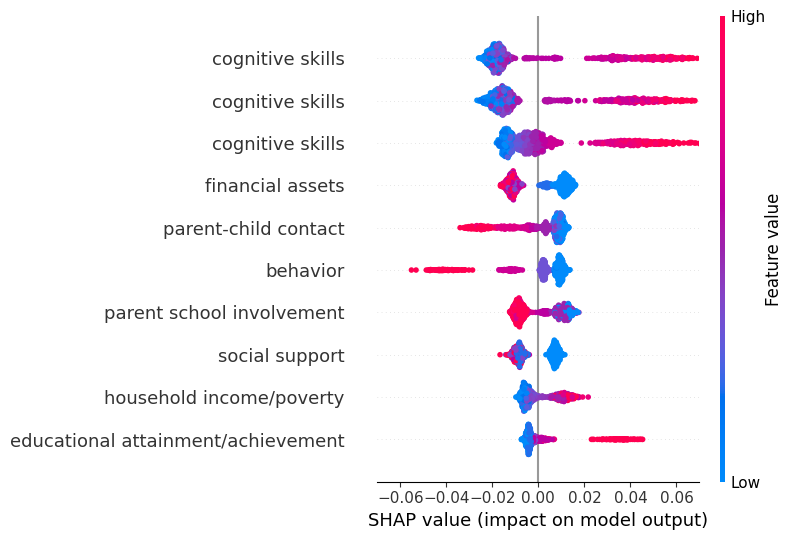

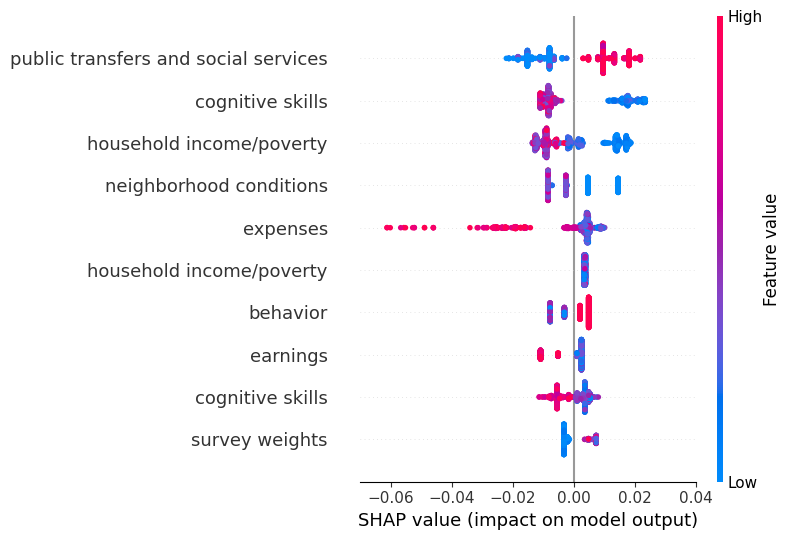

In [38]:
shap.initjs() 
#feature_names = [ (var_dict[v]['respondent'], var_dict[v]['wave']) if v in var_dict else v for v in list(X.columns) ]
feature_names = [ var_dict[v]['subtopics'].split(' ; ')[0] if v in var_dict else v for v in list(X_gpa.columns) ]
shap.summary_plot(shap_values_gpa_common, feature_names = feature_names, max_display=10, show=False)
ax = plt.gca()
ax.set_xlim(-0.07, 0.07) 
plt.savefig(out_dir+'shap_plot_gpa', bbox_inches='tight')
plt.show()

shap.summary_plot(shap_values_grit_common, feature_names = feature_names, max_display=10, show=False)
ax = plt.gca()
ax.set_xlim(-0.07, 0.04) 
plt.savefig(out_dir+'shap_plot_grit', bbox_inches='tight')
plt.show()

In [186]:
lasso_gpa = pd.read_csv(data_dir+'lasso_feature_coeff_gpa.csv', index_col='variable') 
lasso_gpa = lasso_gpa[lasso_gpa['lasso_coeff_absolute'] > 0]
lasso_grit = pd.read_csv(data_dir+'lasso_feature_coeff_grit.csv', index_col='variable')
lasso_grit = lasso_grit[lasso_grit['lasso_coeff_absolute'] > 0]
common_mask = set(lasso_gpa.index.values).intersection(set(lasso_grit.index.values))

df = {}

for var in list(common_mask):
    gpa_coeff = 0
    grit_coeff = 0
    if var in list(lasso_gpa.index.values):
        gpa_coeff = lasso_gpa.loc[var, ]['lasso_coeff_absolute']
    if var in list(lasso_grit.index.values):
        grit_coeff = lasso_grit.loc[var, ]['lasso_coeff_absolute']
    
    #df[var] = (gpa_coeff + grit_coeff) / 2
    df[var] = max(gpa_coeff, grit_coeff)

df = pd.DataFrame.from_dict(df, orient='index')
df.reset_index(inplace=True)
df.columns = ['variable', 'LASSO Coefficient']

df_ret = df.merge(var_topic, how="left", left_on='variable', right_on='variable').sort_values('LASSO Coefficient', ascending=False)
df_ret.set_index('variable', inplace=True)
out = df_ret[['LASSO Coefficient', 'label', 'subtopics', 'wave', 'respondent']]
out.columns = ['LASSO Coefficient', 'Question', 'SubTopics', 'Wave', 'Respondent']
print('Most Important Common Family Background Predictors of GPA-Grit (LASSO):')
display(out[['Question', 'SubTopics', 'Wave', 'Respondent']].head(10))
print(out[['Question', 'SubTopics', 'Wave', 'Respondent']].head(10).to_latex(index=False))

Most Important Common Family Background Predictors of GPA-Grit (LASSO):


,Question,SubTopics,Wave,Respondent
variable,,,,
m1i2ii,In what year did you last work 2 weeks or more...,employment - traditional work,Baseline,Mother
f2citywt_rep1,Father one-year city replicate weight no. 1,survey weights,Year 1,Father
cp3e5_expen,Constructed - Total monthly expense for food e...,expenses,Year 3,Primary Caregiver
f4citywt_rep10,Father five-year city replicate weight no. 10,survey weights,Year 5,Father
q2citywt_rep5,Couple one-year city replicate weight no. 5,survey weights,Year 1,Couple
q3citywt_rep6,Couple three-year city replicate weight no. 6,survey weights,Year 3,Couple
f3citywt_rep9,Father three-year city replicate weight no. 9,survey weights,Year 3,Father
m1citywt_rep2,Mother baseline city replicate weight no. 2,survey weights,Baseline,Mother
f3citywt_rep5,Father three-year city replicate weight no. 5,survey weights,Year 3,Father


\begin{tabular}{llll}
\toprule
Question & SubTopics & Wave & Respondent \\
\midrule
In what year did you last work 2 weeks or more at a regular job? & employment - traditional work & Baseline & Mother \\
Father one-year city replicate weight no. 1 & survey weights & Year 1 & Father \\
Constructed - Total monthly expense for food eaten outside of the house & expenses & Year 3 & Primary Caregiver \\
Father five-year city replicate weight no. 10 & survey weights & Year 5 & Father \\
Couple one-year city replicate weight no. 5 & survey weights & Year 1 & Couple \\
Couple three-year city replicate weight no. 6 & survey weights & Year 3 & Couple \\
Father three-year city replicate weight no. 9 & survey weights & Year 3 & Father \\
Mother baseline city replicate weight no. 2 & survey weights & Baseline & Mother \\
Father three-year city replicate weight no. 5 & survey weights & Year 3 & Father \\
E1a1. In last month, about how much did you/family member receive in government & public transfer

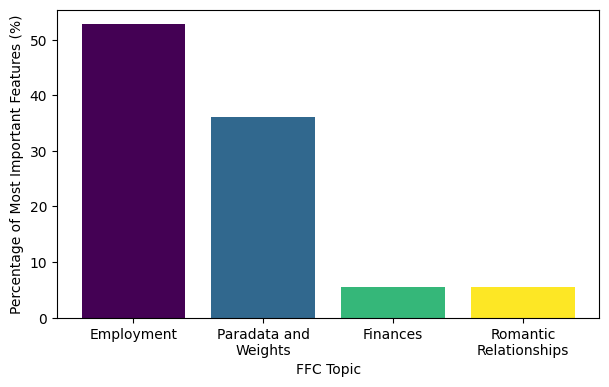

In [184]:
df_ret = df.merge(var_topic, how="left", left_on='variable', right_on='variable').sort_values('LASSO Coefficient', ascending=False)
df_ret.set_index('variable', inplace=True)
out = df_ret[['LASSO Coefficient', 'topic']]
out = out.explode('topic')
# out.columns = ['LASSO Coefficient', 'Question', 'Topic', 'Wave', 'Respondent']
labels = list(out['topic'].unique())
# Count the number of occurrences for each category
plt.figure(figsize=(7, 4))
topics = ['Employment', 'Paradata and\nWeights', 'Finances', 'Romantic\nRelationships']
topic_counts = out['topic'].value_counts(normalize=True)
# Plot a histogram of the number of rows per category
colors = plt.cm.viridis(np.linspace(0, 1, 4))
frequencies = [ x*100 for x in list(topic_counts.values)]
bars = plt.bar(topics, frequencies , color=colors)
# plt.bar(labels, list(category_counts.values), color='skyblue') 
# Add title and labels
plt.xlabel('FFC Topic', fontsize=10)
plt.ylabel('Percentage of Most Important Features (%)', fontsize=10)
plt.savefig(out_dir+'topics_lasso_barplot', bbox_inches='tight')
# Show plot
plt.show()


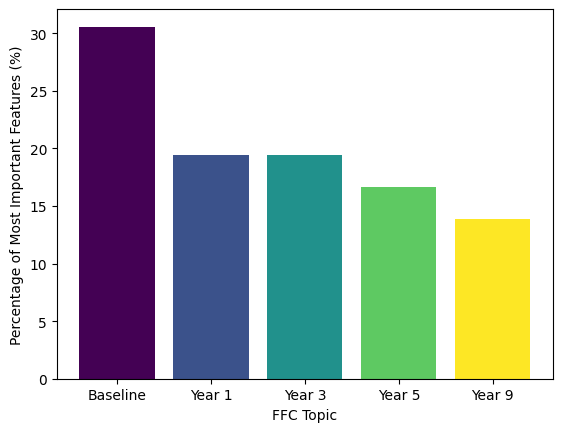

In [183]:
df_ret = df.merge(var_topic, how="left", left_on='variable', right_on='variable').sort_values('LASSO Coefficient', ascending=False)
df_ret.set_index('variable', inplace=True)
out = df_ret[['LASSO Coefficient', 'wave']]
out = out.explode('wave')
# out.columns = ['LASSO Coefficient', 'Question', 'wave', 'Wave', 'Respondent']
labels = list(out['wave'].dropna().unique())
# Count the number of occurrences for each category
topic_counts = out['wave'].value_counts(normalize=True)
# Plot a histogram of the number of rows per category
colors = plt.cm.viridis(np.linspace(0, 1, 5))
frequencies = [ x*100 for x in list(topic_counts.values)]
bars = plt.bar(labels, frequencies , color=colors)
# plt.bar(labels, list(category_counts.values), color='skyblue') 
# Add title and labels
plt.xlabel('FFC Topic', fontsize=10)
plt.ylabel('Percentage of Most Important Features (%)', fontsize=10)
plt.savefig(out_dir+'wave_lasso_barplot', bbox_inches='tight')
# Show plot
plt.show()


In [ ]:
df_ret = df.merge(var_topic, how="left", left_on='variable', right_on='variable').sort_values('LASSO Coefficient', ascending=False)
df_ret.set_index('variable', inplace=True)
out = df_ret[['LASSO Coefficient', 'topic']]
out = out.explode('topic')
# out.columns = ['LASSO Coefficient', 'Question', 'Topic', 'Wave', 'Respondent']
labels = list(out['topic'].unique())
# Count the number of occurrences for each category
print(labels) 
labels = ['Employment', 'Paradata and\nWeights', 'Finances', 'Romantic\nRelationships']
category_counts = out['topic'].value_counts(normalize=True)
# Plot a histogram of the number of rows per category
plt.bar(labels, list(category_counts.values), color='skyblue') 

# Add title and labels
plt.title('Histogram of Row Count per Category', pad=15)
plt.xlabel('Topic')
plt.ylabel('Percentage of Most Important Features')

# Show plot
plt.show()


## Other Visualisation Code

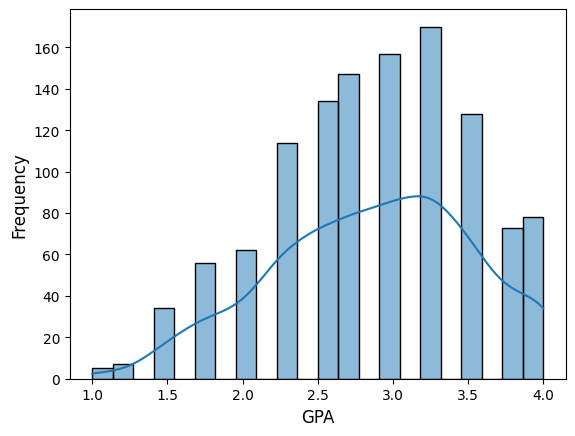

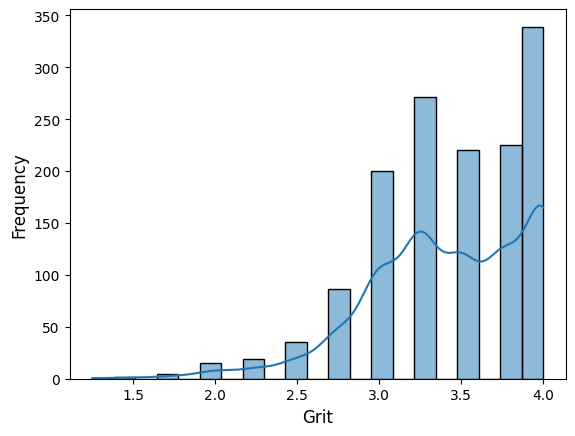

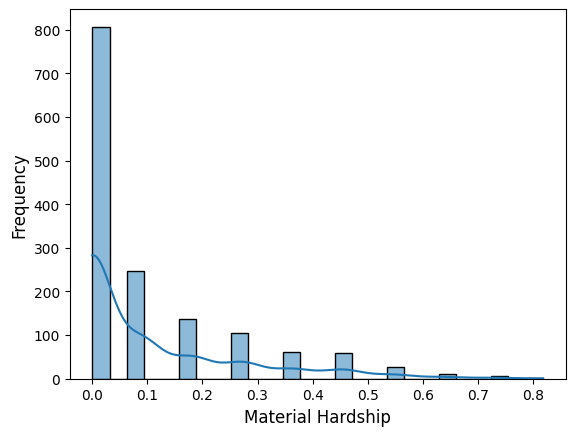

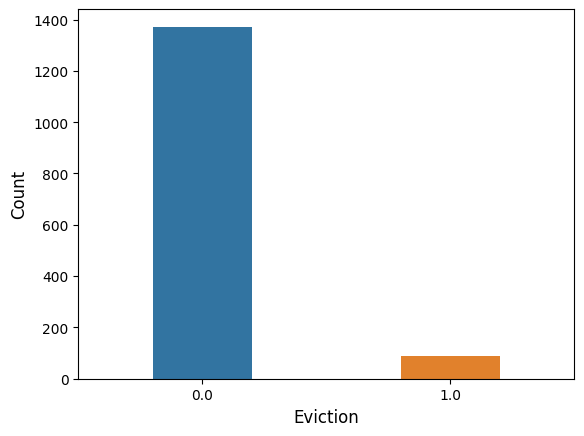

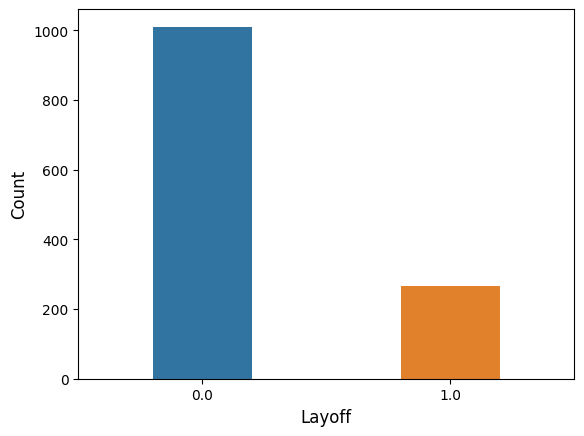

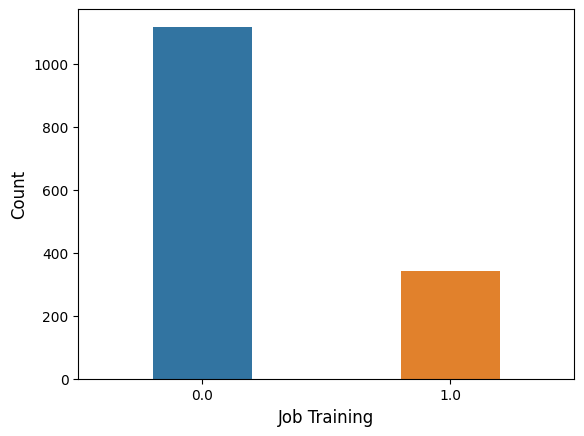

In [40]:
# Plot distributions of outcome variables

outcomes_cont = ['gpa', 'grit', 'materialHardship']
outcomes_cat = ['eviction', 'layoff', 'jobTraining']
labels_cont = ['GPA', 'Grit', 'Material Hardship']
labels_cat = [ 'Eviction', 'Layoff', 'Job Training']

for i,outcome in enumerate(outcomes_cont):
    plt.xlabel(labels_cont[i], fontsize=12)
    plt.ylabel('Frequency', fontsize=12)
    sns.histplot(data=train, x=outcome, kde=True)
    plt.savefig(out_dir +"distribution_{}.png".format(outcome), bbox_inches='tight')
    plt.show()

for i,outcome in enumerate(outcomes_cat):
    plt.xlabel(labels_cat[i], fontsize=12)
    plt.ylabel('Count', fontsize=12)
    ax = sns.countplot(train, x=outcome, width=0.4)
    ax.set(xlabel=labels_cat[i], ylabel='Count')
    ax.set_xticks([0, 1])
    plt.savefig(out_dir +"distribution_{}.png".format(outcome), bbox_inches='tight')
    plt.show()